# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
from scipy import interpolate
from cycler import cycler
from inspect import signature

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook

In [3]:
def get_plot_data(ax, filename) :
    header = ax.get_xlabel()
    data = ax.lines[0].get_xdata()
    for line in ax.lines :
        header = header + ' ' + line.get_label() 
        data = np.vstack((data,line.get_ydata()))
    data = np.transpose(data)
    np.savetxt(filename+'.dat', data, fmt='%.18e', delimiter=' ', newline='\n', header=header, footer='', comments='# ', encoding=None)
    return ('saved to ' + filename) 

In [4]:
def get_plot_data_blocks(ax, filename) :
    for line in ax.lines :
        header = ax.get_xlabel() + ' ' + line.get_label() 
        data = np.vstack((line.get_xdata(),line.get_ydata()))
        data = np.transpose(data)
        np.savetxt(filename+'_'+line.get_label()+'.dat', data, fmt='%.18e', delimiter=' ', newline='\n', header=header, footer='', comments='# ', encoding=None)
    return ('saved to ' + filename) 

# Data structure

In [5]:
data_set = [{'Rl': 40, 'N': 64, 'run_windows' : [1218]}, 
            #{'Rl': 40, 'N': 128, 'run_windows' : [77]}, 
        {'Rl': 60, 'N': 128, 'run_windows' : [487, 418]}, 
        {'Rl': 90, 'N': 256, 'run_windows' : [122, 114, 117, 120]},
        {'Rl': 160, 'N': 512, 'run_windows' : [8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8,8,8,8]}]

# Read files

In [6]:
#reading routine
def read_data_file(common_folder, folder_in, Rl, N, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [7]:
common_folder = "/home/gorbunov8a/data/correlations/"
folder_in = "norm_corr/"
spec_type = "lin"
spec_component = "avg"

In [8]:
# read data files
for simu in data_set : 
    Rl = simu['Rl']; N = simu['N']; run_windows = simu['run_windows']
    [k, nb_of_modes, t, corr_norms] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr_norms", spec_type, spec_component, run_windows) # total_t - all energy transgers to the shell k
    #[k, nb_of_modes, t, corr_com] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr_complex", spec_type, spec_component, run_windows) # total_t - all energy transgers to the shell k
    [k, nb_of_modes, t, avg] = read_data_file(common_folder, folder_in, Rl, N, "avg_norms", spec_type, spec_component, run_windows)
    corr = corr_norms - avg*avg[0,:] 
    simu.update({'k': k, 'nb_of_modes' : nb_of_modes, 'time' : t, 'corr_norms' : corr_norms, 'corr' : corr, 'avg': avg})
    del k, nb_of_modes, t, corr_norms, avg

reading file: /home/gorbunov8a/data/correlations/rl40_N64/norm_corr/run1/two_point_corr_norms_lin_Cavg_wi=001218.table
reading file: /home/gorbunov8a/data/correlations/rl40_N64/norm_corr/run1/avg_norms_lin_Cavg_wi=001218.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run1/two_point_corr_norms_lin_Cavg_wi=487.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run2/two_point_corr_norms_lin_Cavg_wi=418.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run1/avg_norms_lin_Cavg_wi=487.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run2/avg_norms_lin_Cavg_wi=418.table
reading file: /home/gorbunov8a/data/correlations/rl90_N256/norm_corr/run1/two_point_corr_norms_lin_Cavg_wi=122.table
reading file: /home/gorbunov8a/data/correlations/rl90_N256/norm_corr/run2/two_point_corr_norms_lin_Cavg_wi=114.table
reading file: /home/gorbunov8a/data/correlations/rl90_N256/norm_corr/run3/two_point_corr_norm

# Parameters

In [9]:
nu = 0.0001
pi = np.pi
for simu in data_set : 
    if (simu['Rl'] == 40) :
        if (simu['N'] == 64) :
            simu['lambda'] = 0.57; simu['eta'] = 0.511e-1; simu['dissip_rate'] = 0.145e-6; 
            simu['ekin'] = 5.34e-5;  simu['ik_max'] = 28;
        if (simu['N'] == 128) :
            simu['lambda'] = 0.29; simu['eta'] = 0.246e-1; simu['dissip_rate'] = 0.270e-5
            simu['ekin'] = 0.2364e-3; simu['ik_max'] = 54;
    if (simu['Rl'] == 60) :
        simu['lambda'] = 0.378; simu['eta'] = 0.0254807; simu['dissip_rate'] = 0.2244E-5
        simu['ekin'] = 3.53e-4; simu['ik_max'] = 54;
    if (simu['Rl'] == 90) :
        simu['lambda'] = 0.2352; simu['eta'] = 0.126e-1; simu['dissip_rate'] = 0.3919e-4;
        simu['ekin'] = 2.25e-3;  simu['ik_max'] = 100;
    if (simu['Rl'] == 160) :
        simu['lambda'] = 0.155; simu['eta'] = 0.006436; simu['dissip_rate'] = 0.6E-3; 
        simu['ekin'] = 1.59e-2;  simu['ik_max'] = 210;
    if (simu['Rl'] == 250) :
        simu['lambda'] = 0.1; simu['eta'] = 0.32e-2; simu['dissip_rate'] = 0.94e-2;
        simu['ekin'] = 0.1013; 
    simu['urms'] = np.sqrt(2.0/3.0*simu['ekin']); simu['L'] = np.sqrt(2.0/3.0*simu['ekin'])**3/simu['dissip_rate']
    #simu['t0']=simu['dissip_rate']**(-1.0/3.0)*simu['L']**(2.0/3.0) #large scale eddy-turnover time characteristic scale 
    simu['t0'] = simu['L']/simu['urms']
    simu['k_norm'] = 1/(2.0*np.pi/simu['L']) # integral scale as non-dimensionalisation factor
    simu['spatial_scales'] = np.array([simu['L'], simu['lambda'], simu['eta']])
    simu['spher_coef'] = 4.0*np.pi*simu['k']**2.0/simu['nb_of_modes']
    #find wavenumber corresponding to the dealiasing cut-off
    shift_init = simu['N']//4
    #simu['ik_max'] = shift_init + (np.argwhere(simu['spher_coef'][shift_init::]>1.0205)[0])[0]

In [10]:
#cut-ff tails
threshold = 5e-16
for simu in data_set :
    simu['it_max'] = np.array(np.full_like(simu['k'],len(simu['time'])-1),dtype=int)
    for ik in range(len(simu['k'])) :
        ar = np.nonzero(simu['corr'][:,ik] < threshold)[0]
        if (ar.size != 0) : 
            simu['it_max'][ik] = np.int_(ar[0])
    simu['ik_max'] = np.argmin(simu['it_max'])

# Plot appearance

In [11]:
nb_of_curves = 7

for simu in data_set : 
    simu['indices_of_k_to_plot'] = np.int_(np.linspace(13, simu['ik_max'], nb_of_curves))
    simu['indices_of_k_to_plot0'] = np.int_(np.linspace(simu['ik_max'], np.max(simu['k']), nb_of_curves))
    simu['indices_of_k_to_plot2'] = np.array(np.searchsorted(simu['k']*simu['eta'], np.linspace(0.3, 1.3, nb_of_curves)),dtype=int)
    # legends : 
    simu['legend'] = r"$R_{\lambda}=$" + str(simu['Rl']) + r"$, N = $" + str(simu['N'])
    simu['legend_short'] = r"$R_{\lambda}=$" + str(simu['Rl'])
    # COLORS vs Rl
    if (simu['Rl'] == 60) : 
        simu.update({'color': 'blue'})
    elif (simu['Rl'] == 90) : 
        simu.update({'color': 'orange'})
    elif (simu['Rl'] == 160) : 
        simu.update({'color': 'green'})  
    elif (simu['Rl'] == 250) : 
        simu.update({'color': 'red'})  

In [12]:
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=11)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
linestyles = [(0, (5, 10)), '-', '--', ':', (0, (3, 5, 1, 5, 1, 5)), '-.']
plt.rc('axes', prop_cycle=default_cycler)

# Spatial compensated spectrum from C_2(t=0,k)


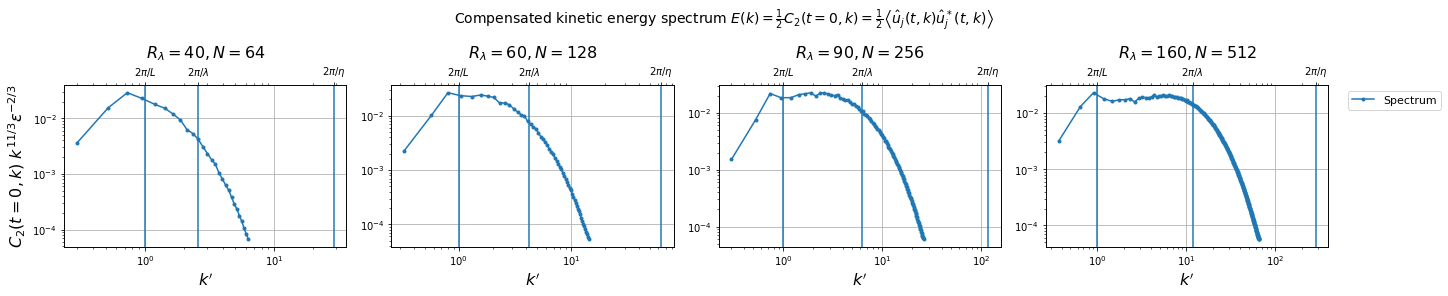

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Compensated kinetic energy spectrum $E(k) = \frac{1}{2} C_2(t=0, k) = \frac{1}{2} \left<\hat{u}_j(t,k) \hat{u}_j^* (t,k) \right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    simu['kinetic_energy'] = 0.5*simu['corr'][0,::]
    indices = slice(0,simu['ik_max'])
    ax[i].plot(simu['k'][indices]*simu['k_norm'], simu['kinetic_energy'][indices]*simu['k'][indices]**(11.0/3.0)*simu['dissip_rate']**(-2.0/3.0)*simu['spher_coef'][indices], '.-', label='Spectrum')
    ax[i].set(xscale='log',yscale='log',xlabel=r'$k^\prime$', title=simu['legend']); ax[i].grid()
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t=0,k) \ k^{11/3} \epsilon^{-2/3}$')
    # plot spatial scales
    vertical_lines = 2.0*np.pi/simu['spatial_scales']*simu['k_norm']
    for line in vertical_lines : ax[i].axvline(x=line)     
    ax2 = ax[i].twiny(); ax2.set(xscale=ax[i].get_xscale(), yscale=ax[i].get_yscale(), xlim = ax[i].get_xlim())
    ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
    if (i == len(data_set)-1) : lgd = ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Two-point spatio-temporal correlation function

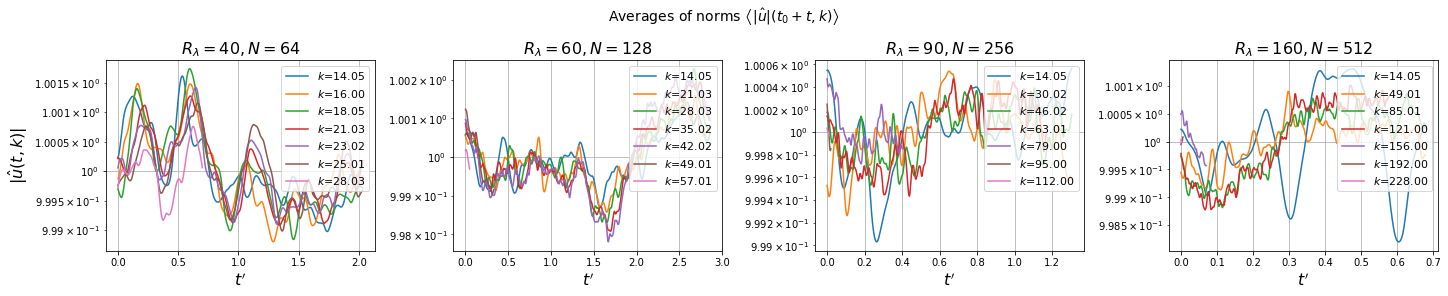

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Averages of norms $\left< |\hat{u}|(t_0+t, k) \right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot'] :
        time_sl = np.s_[0:simu['it_max'][ik]]
        ax[i].plot(simu['time'][time_sl]/simu['t0'], simu['avg'][time_sl,ik]/np.mean(simu['avg'][time_sl,ik]) , '-', label=r'$k$=%2.2f' % (simu['k'][ik]))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,0.3])
    if (i == 0) : ax[i].set(ylabel=r'$|\hat{u}(t,k)|$')
    lgd = ax[i].legend(loc='upper right')

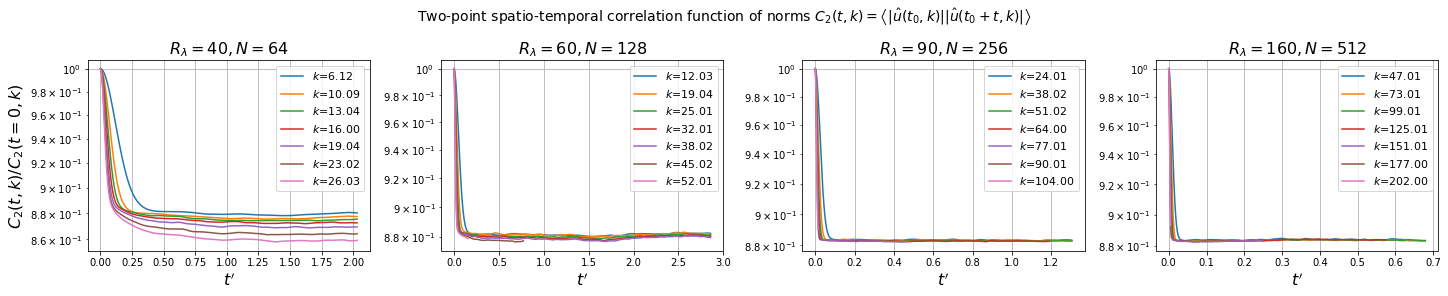

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(4*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms $C_2(t,k) = \left< |\hat{u}(t_0, k)| |\hat{u}(t _0 + t, k)|\right>$', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot2'] :
        time_sl = np.s_[0:simu['it_max'][ik]]
        ax[i].plot(simu['time'][time_sl]/simu['t0'], simu['corr_norms'][time_sl,ik]/simu['corr_norms'][0,ik] , '-', label=r'$k$=%2.2f' % (simu['k'][ik]))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,0.3])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right')

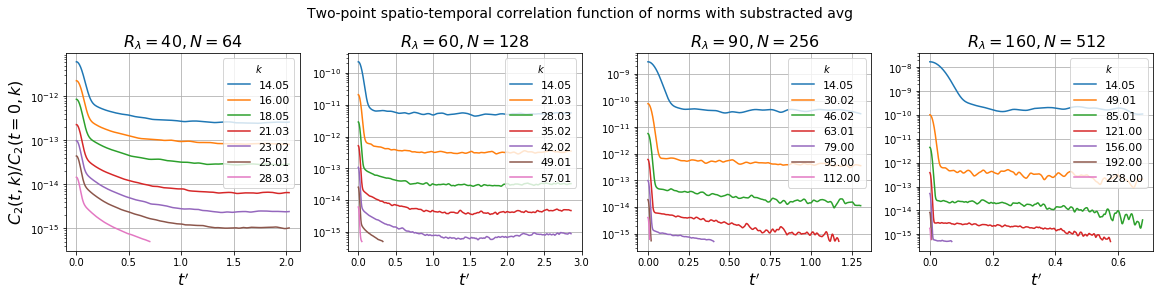

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot'] :
        time_sl = np.s_[0:simu['it_max'][ik]]
        ax[i].plot(simu['time'][time_sl]/simu['t0'], simu['corr'][time_sl,ik] , '-', label=r'%2.2f' % (simu['k'][ik]))
        #ax[i].set(xlim=[0,1.1], ylim=[10e-4,1.0])
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t^\prime$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,0.3])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right', title=r'$k$')

In [17]:
# fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
# fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
# for i in list(range(len(data_set))) :
#     simu = data_set[i]
#     for ik in simu['indices_of_k_to_plot2'] :
#         ax[i].plot(simu['time']/simu['t0']*simu['k'][ik]*simu['L'], scipy.signal.wiener(simu['corr'][:,ik] / simu['corr'][0,ik], mysize=50), '-', \
#                    label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
#     ax[i].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 k L$', title=simu['legend']); ax[i].grid()
#     #ax[i].set(xlim=[0,100.0]); ax[i].set(ylim=[10e-4,1.0])
#     if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
#     lgd = ax[i].legend(loc='upper right', title=r'$k\eta$')

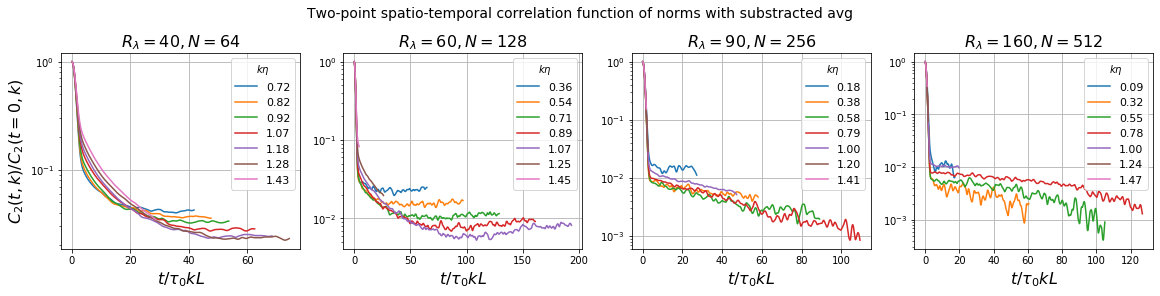

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot'] :
        time_sl = np.s_[0:simu['it_max'][ik]]
        ax[i].plot(simu['time'][time_sl]/simu['t0']*simu['k'][ik]*simu['L'], simu['corr'][time_sl,ik] / simu['corr'][0,ik], '-', \
                   label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    ax[i].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 k L$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,100.0]); ax[i].set(ylim=[10e-4,1.0])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
    lgd = ax[i].legend(loc='upper right', title=r'$k\eta$')

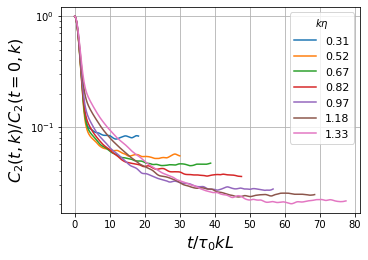

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
simu = data_set[0]

for ik in simu['indices_of_k_to_plot2'] :
    b_l = np.searchsorted(simu['time']/simu['t0']*simu['k'][ik]*simu['L'], 50.0)-1
    sl = np.s_[0:b_l]
    time_sl = np.s_[0:simu['it_max'][ik]]
    ax.plot(simu['time'][time_sl]/simu['t0']*simu['k'][ik]*simu['L'], simu['corr'][time_sl,ik] / simu['corr'][0,ik], '-', label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 k L$'); ax.grid()
#ax[i].set(xlim=[0,100.0]); ax[i].set(ylim=[10e-4,1.0])
ax.set(ylabel=r'$C_2(t,k) / C_2(t=0,k)$')
lgd = ax.legend(loc='upper right', title=r'$k\eta$')
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/2pcorrVStkLargeTimes.pdf')
# pp.savefig()
# pp.close()

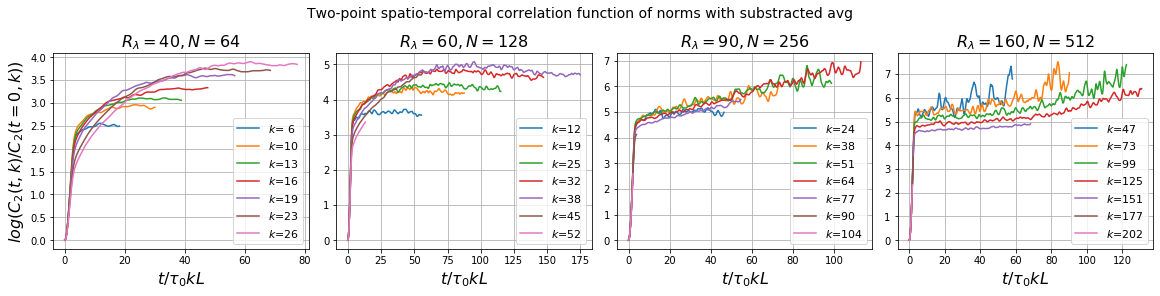

In [20]:
# log of C2
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot2'] :
        time_sl = np.s_[0:simu['it_max'][ik]]
        x = simu['time'][time_sl]/simu['t0']*simu['k'][ik]*simu['L']
        ax[i].plot(x, -np.log(simu['corr'][time_sl,ik] / simu['corr'][0,ik]), '-', label=r'$k$=%2.0f' % (simu['k'][ik]))
    #x[i].plot(x, x**2, 'k--', label=r'$t^2$')
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0 k L$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,1.0])
    if (i == 0) : ax[i].set(ylabel=r'$log(C_2(t,k) / C_2(t=0,k))$')
    lgd = ax[i].legend(loc='best')

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


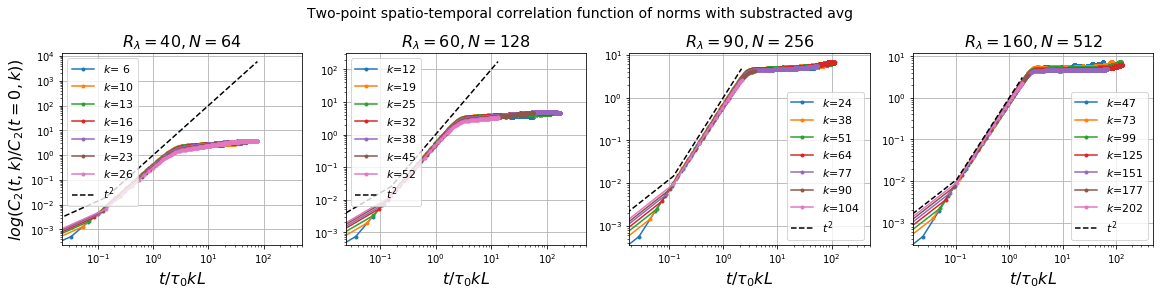

In [21]:
# check the slope -> crossover point
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot2'] :
        time_sl = np.s_[0:simu['it_max'][ik]]
        x = simu['time'][time_sl]/simu['t0']*simu['k'][ik]*simu['L']
        ax[i].plot(x, -np.log(simu['corr'][time_sl,ik] / simu['corr'][0,ik]), '.-', label=r'$k$=%2.0f' % (simu['k'][ik]))
    ax[i].plot(x, x**2, 'k--', label=r'$t^2$')
    ax[i].set(xscale='log',yscale='log', xlabel=r'$t/\tau_0 k L$', title=simu['legend']); ax[i].grid()
    ax[i].set(xlim=[0,500.0])
    if (i == 0) : ax[i].set(ylabel=r'$log(C_2(t,k) / C_2(t=0,k))$')
    lgd = ax[i].legend(loc='best')

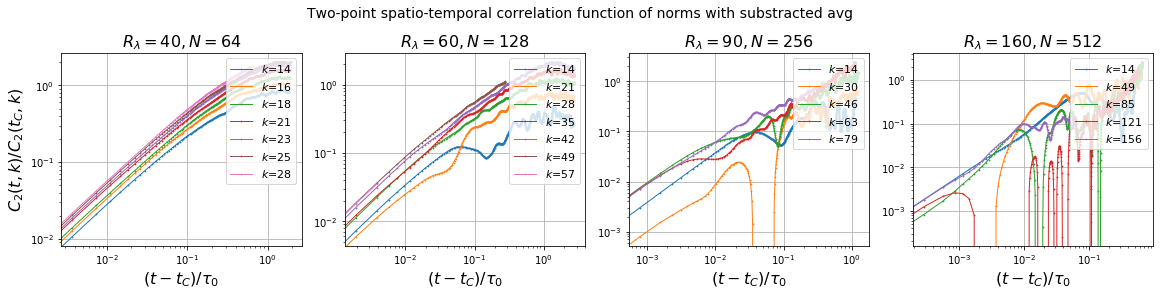

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
crossover_kl = 4.0
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot'] :
        x = simu['time'][:]/simu['t0']*simu['k'][ik]*simu['L']
        crossover_index = np.searchsorted(x, crossover_kl)
        if (simu['it_max'][ik] > crossover_index) :
            time_sl = np.s_[crossover_index:simu['it_max'][ik]]
            ax[i].plot((simu['time'][time_sl]-simu['time'][crossover_index])/simu['t0']*(simu['k'][ik]*simu['L'])**0, \
                   -np.log(simu['corr'][time_sl,ik] / simu['corr'][crossover_index,ik]), '.-', label=r'$k$=%2.0f' % (simu['k'][ik]), lw = 1, markersize=1.5)
    #ax[i].plot(x,1e-0*x, 'k--')
    #ax[i].plot(x,10e-0*x**2, 'r--')
    ax[i].set(xscale='log',yscale='log', xlabel=r'$(t-t_C)/\tau_0$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,2000.0])
    #ax[i].set(ylim=[0.1,1.0])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t_C,k)$')
    lgd = ax[i].legend(loc='upper right')

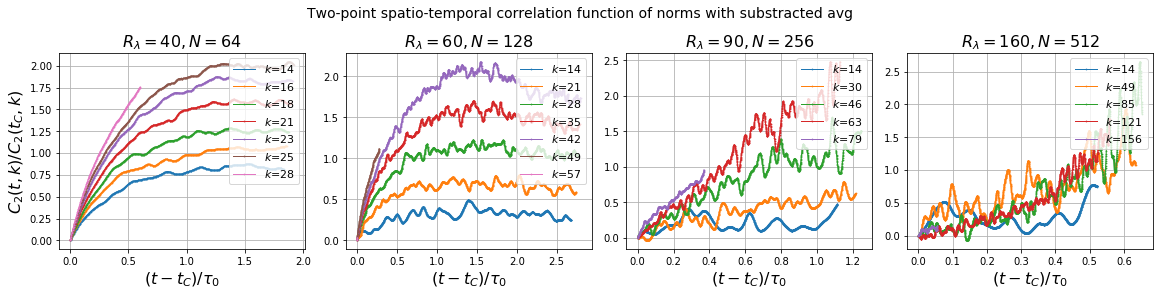

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for ik in simu['indices_of_k_to_plot'] :
        x = simu['time'][:]/simu['t0']*simu['k'][ik]*simu['L']
        crossover_index = np.searchsorted(x, crossover_kl)
        if (simu['it_max'][ik] > crossover_index) :
            time_sl = np.s_[crossover_index:simu['it_max'][ik]]
            ax[i].plot((simu['time'][time_sl]-simu['time'][crossover_index])/simu['t0']*(simu['k'][ik]*simu['L'])**0, \
                   -np.log(simu['corr'][time_sl,ik] / simu['corr'][crossover_index,ik]), '.-', label=r'$k$=%2.0f' % (simu['k'][ik]), lw = 1, markersize=1.5)
    #ax[i].plot(x,1e-0*x, 'k--')
    #ax[i].plot(x,10e-0*x**2, 'r--')
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$(t-t_C)/\tau_0$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,2000.0])
    #ax[i].set(ylim=[0.1,1.0])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t_C,k)$')
    lgd = ax[i].legend(loc='upper right')

# Correlation fit

In [24]:
# Define the functions to fit
def exp_poly_s(x,a,b,c) :
    return np.exp(a*(x**2) + b*x + c)
def exp_poly_l(x,a,b) :
    return np.exp(a*x + b)

In [25]:
def simple_gaussian(x, a, c):   
    return c*np.exp(-a * (x)**2.0) 
def simple_gaussian_jacobian(x, a, c):   
    return np.transpose([-(x**2.0)*c*np.exp(-a * (x)**2.0), np.exp(-a * (x)**2.0)])

In [26]:
def simple_exponent(x, a, c):   
    return c*np.exp(-a * x) 
def simple_exponent_jacobian(x, a, c):   
    return np.transpose([-(x)*c*np.exp(-a * x), np.exp(-a * x)])

In [27]:
def try_to_fit(curve_function, xdata, ydata, sigma_ydata=None, jacobian_function=None) :
    number_of_params_of_optimization = len(signature(curve_function).parameters)-1
    coefficients = np.ndarray(shape=(number_of_params_of_optimization), dtype=float) 
    covariance_matrix = np.ndarray(shape=(number_of_params_of_optimization, number_of_params_of_optimization), dtype=float) 
    try :
        coefficients, covariance_matrix = curve_fit(curve_function, xdata, ydata, sigma=sigma_ydata, jac=jacobian_function)
    except :
        #print('[DEBUG] Failed optimization for ik = ', ik)
        coefficients.fill(np.nan); covariance_matrix.fill(np.nan)
    return [coefficients, covariance_matrix]

# Crossover time estimation

In [28]:
# compute derivatives of the corr function
for simu in data_set : 
    simu['deriv1'] = np.ndarray(shape=(len(simu['k']), len(simu['time'])), dtype=float)
    simu['deriv2'] = np.ndarray(shape=(len(simu['k']), len(simu['time'])), dtype=float)
    for ik in range(len(simu['k'])) :
        sl = np.s_[0:simu['it_max'][ik]]
        sl = np.s_[0:len(simu['time'])]
        #simu['deriv1'][ik,:] = np.gradient(simu['corr'][sl,ik] / simu['corr'][0,ik], simu['time'][sl]/simu['t0'], edge_order=1)
        simu['deriv1'][ik,:] = np.gradient(np.log(simu['corr'][sl,ik] / simu['corr'][0,ik]), simu['time'][sl]/simu['t0'], edge_order=1)
        simu['deriv2'][ik,:] = np.gradient(simu['deriv1'][ik,:] / (simu['corr'][sl,ik] / simu['corr'][0,ik]), simu['time'][sl]/simu['t0'], edge_order=1)

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


## Through 1st derivative

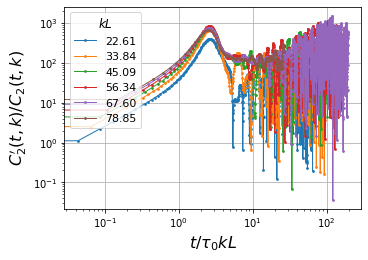

In [29]:
# check [c'(t)/c(t)]
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:-1])) :
    ik = simu['indices_of_k_to_plot'][i]
    time_sl = np.s_[0:simu['it_max'][ik]]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    ax.plot(x[time_sl], np.abs(simu['deriv1'][ik,time_sl]/(simu['corr'][time_sl,ik] / simu['corr'][0,ik])), '.-', linewidth=1, color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L'])) #ls=(0, (3, 5)),
    #ax.plot(x, 2.0*simu['optim_coef_s'][ik, 0]*simu['time'][:]/simu['t0'], '-', linewidth=1, color=colors[i])
    #ax.axvline(x=x[simu['itc_deriv'][ik]], color=colors[i])
ax.set(xscale='log',yscale='log', xlabel=r'$t/\tau_0 kL$', ylabel=r'$C_2^\prime(t, k)/C_2(t, k)$'); ax.grid()
#ax.set(xlim=[0,0.3], ylim=[-120,20])
lgd = ax.legend(loc='best', title=r'$kL$', title_fontsize=12)
# ax.axvspan(0, x[simu['itc_deriv'][ik]-3], facecolor='green', alpha=0.15)
# plt.text(0.11, 0.92, "Gaussian", {'color': 'darkgreen', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
# ax.axvspan(7.8, 15 , facecolor='purple', alpha=0.15)
# plt.text(0.76, 0.92, "Exponential", {'color': 'darkviolet', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
# plt.text(0.35, 0.5, "Crossover", {'color': 'black', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)

# pp = PdfPages('Images/Paper/derivC2vst.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [30]:
# fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
# simu = data_set[3] 
# x = simu['time']/simu['t0']
# ik = 22
# time_sl = np.s_[0:simu['it_max'][ik]]
# ax.plot(simu['time'][time_sl]/simu['t0']*(simu['k'][ik])**0, simu['deriv1'][ik,time_sl]/(simu['corr'][time_sl,ik] / simu['corr'][0,ik]), '.-', linewidth=1, color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['L'])) #ls=(0, (3, 5)),
# ax.plot(simu['time'][time_sl]/simu['t0']*(simu['k'][ik])**0, -2.0*simu['optim_coef_s'][ik, 0]*simu['time'][time_sl]/simu['t0'], '-', linewidth=1, color=colors[i])
# ax.set(xscale='linear',yscale='linear', xlabel=r'$t$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title=None); ax.grid()
# #*ax.set(xlim=[0,0.05], ylim=[-1500,0])
# lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$', title_fontsize=12)

In [31]:
# find crossover time as min of [c'(t)/c(t)]
for simu in data_set : 
    simu['itc_deriv'] = np.ndarray(shape=(len(simu['k'])), dtype=int)
    for ik in range(len(simu['k'])) :
        b_l = np.searchsorted(simu['time']/simu['t0']*simu['k'][ik]*simu['L'], 2.5)
        time_sl = np.s_[0:b_l]
        #time_sl = np.s_[0:-1]
        simu['itc_deriv'][ik] = np.argmin(simu['deriv1'][ik,time_sl]/(simu['corr'][time_sl,ik] / simu['corr'][0,ik]))

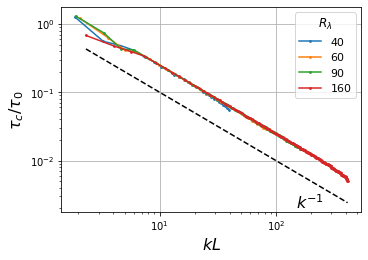

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))

for simu in data_set : 
    k_slice = np.s_[0:simu['ik_max']]
    x = simu['k'][k_slice]*simu['L']
    ax.plot(x, simu['time'][simu['itc_deriv'][k_slice]]/simu['t0'], '.-', label=simu['Rl'], markersize=3.5)
ax.plot(x, x**(-1), 'k--')
ax.annotate(r'$k^{-1}$', xy=(150, 2e-3), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$\tau_{c}/\tau_0$'); ax.grid(True)
lgd = ax.legend(loc='best', title=r'$R_\lambda$',title_fontsize=12)

# pp = PdfPages('Images/Paper/crossoverTimevskL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

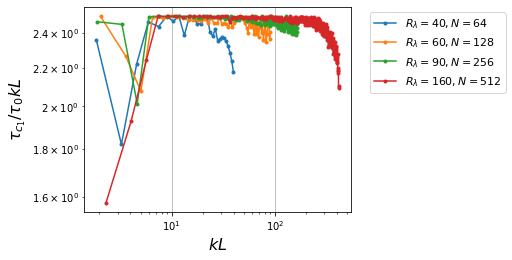

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(7,3.5))

for simu in data_set : 
    k_slice = np.s_[0:simu['ik_max']]
    x = simu['k'][k_slice]*simu['L']
    ax.plot(x, simu['time'][simu['itc_deriv'][k_slice]]/simu['t0']*x**(1), '.-', label=simu['legend'])
ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$\tau_{c_1}/\tau_0 kL$'); ax.grid(True)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title_fontsize=12)
plt.show()

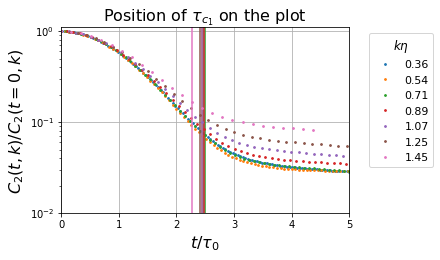

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    ax.plot(x[sl], simu['corr'][sl,ik] / simu['corr'][0,ik], '.', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    #ax.plot(x[sl], exp_poly_s(x[sl], *simu['optim_coef_s'][ik,:]), linewidth=1, color=colors[i]) 
    ax.axvline(x=x[simu['itc_deriv'][ik]], color=colors[i])
ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title=r'Position of $\tau_{c_1}$ on the plot'); ax.grid()
ax.set(ylim=[10e-3,1.1], xlim=[0,5.0])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$', title_fontsize=12)

# pp = PdfPages('Images/Correlations/2pcorr_small2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

## Through 2nd derivative

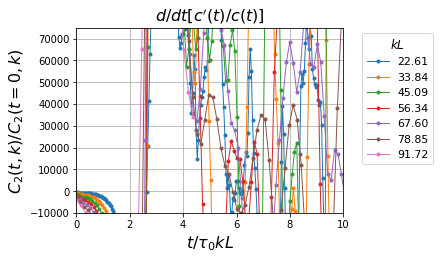

In [35]:
# check d/dt[c'(t)/c(t)]
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot0'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    time_sl = np.s_[0:simu['it_max'][ik]]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**(1)
    ax.plot(x[time_sl], simu['deriv2'][ik,time_sl]/(simu['corr'][time_sl,ik] / simu['corr'][0,ik]), '.-', linewidth=1, color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['L'])) #ls=(0, (3, 5)),
    #ax.plot(x, np.full_like(x, 2.0*simu['optim_coef_s'][ik, 0]), '--', linewidth=1, color=colors[i])
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title=r'$d/dt[c^\prime(t)/c(t)]$'); ax.grid()
ax.set(xlim=[0,10], ylim=[-1.0e+4, 7.5e4]);
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$', title_fontsize=12)

In [36]:
# find crossover time as min of d/dt[c'(t)/c(t)]
for simu in data_set : 
    simu['itc_deriv2'] = np.ndarray(shape=len(simu['k']), dtype=int)
    for ik in range(len(simu['k'])) :
        b_l = np.searchsorted(simu['time']/simu['t0']*simu['k'][ik]*simu['L'], 5.0)
        time_sl = np.s_[0:b_l]
        #time_sl = np.s_[0:-1]
        simu['itc_deriv2'][ik] = np.argmax(simu['deriv2'][ik,time_sl]/(simu['corr'][time_sl,ik] / simu['corr'][0,ik]))

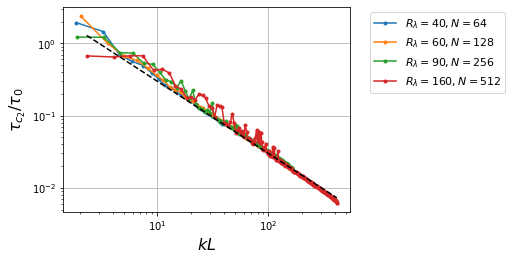

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(7,3.5))

for simu in data_set[0:4] : 
    k_slice = np.s_[0:simu['ik_max']]
    x = simu['k'][k_slice]*simu['L']
    ax.plot(x, simu['time'][simu['itc_deriv2'][k_slice]]/simu['t0'], '.-', label=simu['legend'])
ax.plot(x, 3e0*x**(-1), 'k--')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$\tau_{c_2}/\tau_0$'); ax.grid(True)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title_fontsize=12)
plt.show()

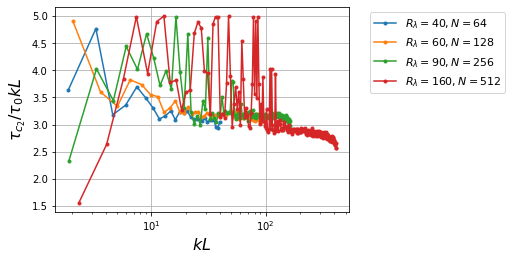

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(7,3.5))

for simu in data_set[0:4] : 
    k_slice = np.s_[0:simu['ik_max']]
    x = simu['k'][k_slice]*simu['L']
    ax.plot(x, simu['time'][simu['itc_deriv2'][k_slice]]/simu['t0']*(x**(1)), '.-', label=simu['legend'])
ax.set(xscale='log', yscale='linear', xlabel=r'$kL$', ylabel=r'$\tau_{c_2}/\tau_0 kL$'); ax.grid(True)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title_fontsize=12)
plt.show()

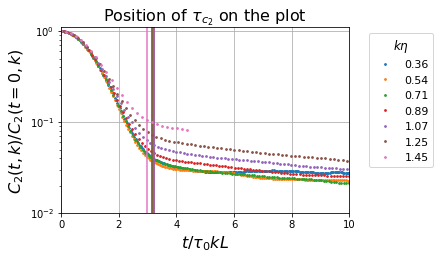

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    ax.plot(simu['time'][sl]/simu['t0']*(simu['k'][ik]*simu['L'])**1, simu['corr'][sl,ik] / simu['corr'][0,ik], '.', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    #ax.plot(simu['time'][sl]/simu['t0']*simu['k'][ik]*simu['L'], simple_gaussian(x[sl], *simu['optim_coef_s'][ik,:]), linewidth=1, color=colors[i]) 
    ax.axvline(x=simu['time'][simu['itc_deriv2'][ik]]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title=r'Position of $\tau_{c_2}$ on the plot'); ax.grid()
ax.set(ylim=[10e-3,1.1], xlim=[0,10])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$', title_fontsize=12)

# pp = PdfPages('Images/Correlations/2pcorr_small2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

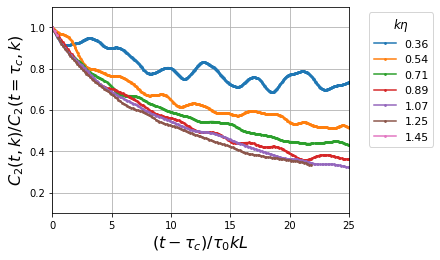

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    it_crossover = np.searchsorted(simu['time'], simu['time'][simu['itc_deriv2'][ik]] + 1.0*simu['t0']/(simu['k'][ik]*simu['L']))
    sl = np.s_[it_crossover:simu['it_max'][ik]]
    ax.plot((simu['time'][sl]-simu['time'][it_crossover])/simu['t0']*(simu['k'][ik]*simu['L'])**1, simu['corr'][sl,ik] / simu['corr'][it_crossover,ik], '.-', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
ax.set(xscale='linear',yscale='linear', xlabel=r'$(t-\tau_c)/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=\tau_c,k)$', title=None); ax.grid()
ax.set(ylim=[10e-2,1.1], xlim=[0,25])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$', title_fontsize=12)

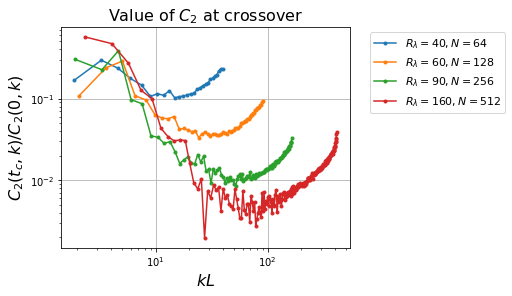

In [41]:
# c2 value at the crossover vs k

fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(7,4))

for i in range(len(data_set[0:4])) : 
    simu = data_set[i]
    k_slice = np.s_[0:simu['ik_max']]
    x = simu['k'][k_slice]*simu['L']
    c2_at_crossover = [simu['corr'][simu['itc_deriv2'][ik],ik] for ik in range(len(simu['k']))]
    ax.plot(x, c2_at_crossover[k_slice]/ simu['corr'][0,k_slice], '.-', label=simu['legend'], color=colors[i])
    #ax.plot(x, simu['corr'][0,k_slice], '.-', label=simu['legend'], color=colors[i])
#ax.plot(x, 5e-2*x**(-11/3), 'k--')
#ax.plot(x, 5e-5*x**(1), 'k--')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$C_2(t_c,k) / C_2(0,k)$', title=r'Value of $C_2$ at crossover'); ax.grid(True)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title_fontsize=12)
plt.show()

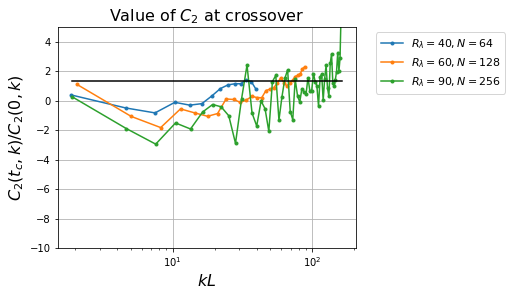

In [42]:
# slope of C2(tc) vs k
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(7,4))

for simu in data_set[0:3] : 
    k_slice = np.s_[0:simu['ik_max']:2]
    x = simu['k'][k_slice]*simu['L']
    c2_at_crossover = [simu['corr'][simu['itc_deriv2'][ik],ik] for ik in range(len(simu['k']))]
    ax.plot(x, np.gradient(np.log(c2_at_crossover[k_slice]/ simu['corr'][0,k_slice]), np.log(x)), '.-', label=simu['legend'])
    #ax.plot(x, np.gradient(np.log(simu['corr'][0,k_slice]), np.log(x)), '.-', label=simu['legend'])

ax.plot(x, np.full_like(x, 4/3), 'k-')
ax.set(ylim=[-10,5])
ax.set(xscale='log', yscale='linear', xlabel=r'$kL$', ylabel=r'$C_2(t_c,k) / C_2(0,k)$', title=r'Value of $C_2$ at crossover'); ax.grid(True)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title_fontsize=12)
plt.show()

# Short time fit

In [43]:
tk1_fit_short = 0.0
tk2_fit_short = 1.0

for simu in data_set : 
    simu['optim_coef_s'] = np.ndarray(shape=(len(simu['k']), 3), dtype=float)
    for ik in range(len(simu['k'])) :
        # fit the 2-point correlation function :
        time_sl = np.s_[0:simu['it_max'][ik]]
        a_s = 0
        b_s = np.searchsorted(simu['time'][time_sl]/simu['t0']*simu['k'][ik]*simu['L'], tk2_fit_short)
        try :
            # polynomial fit
            simu['optim_coef_s'][ik, :] = np.polyfit(simu['time'][a_s:b_s]/simu['t0'], np.log(simu['corr'][a_s:b_s,ik]/simu['corr'][0,ik]), 2)
        #simu['optim_coef_s'][ik, :] = try_to_fit(simple_gaussian, simu['time'][a_s:b_s]/simu['t0'], simu['corr'][a_s:b_s,ik]/simu['corr'][0,ik],jacobian_function=simple_gaussian_jacobian)[0]
        except :
            print('Failed polyfit for ik = ', ik)
            simu['optim_coef_s'][ik,:].fill(np.nan)
            continue

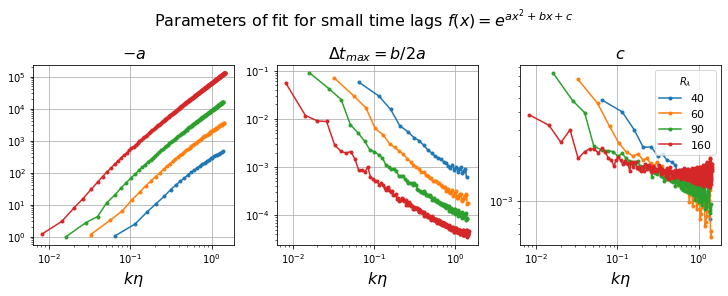

In [44]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
for simu in data_set : 
    sl = np.s_[0:simu['ik_max']]
    ax_a.plot(simu['k'][sl]*simu['eta'], -simu['optim_coef_s'][sl, 0], '.-')
    ax_b.plot(simu['k'][sl]*simu['eta'], simu['optim_coef_s'][sl, 1]/(2.0*simu['optim_coef_s'][sl, 0]), '.-')
    ax_c.plot(simu['k'][sl]*simu['eta'], simu['optim_coef_s'][sl, 2], '.-', label=simu['Rl'])
ax_a.set(xscale='log', yscale='log', title=r'$-a$', xlabel=r'$k\eta$'); ax_a.grid()
ax_b.set(xscale='log', yscale='log', title=r'$\Delta t_{max} = b/2a$', xlabel=r'$k\eta$'); ax_b.grid(); 
ax_c.set(xscale='log', yscale='log', title=r'$c$', xlabel=r'$k\eta$'); ax_c.grid()
ax_c.legend(title=r'$R_\lambda$')
fig.suptitle('Parameters of fit for small time lags $f(x) = e^{a x^2 + bx + c}$', fontsize=16)

# pp = PdfPages('../Images/Correlations/norm_corr_fit_alphas.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

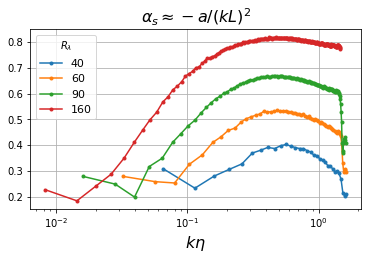

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
for simu in data_set : 
    ax.plot(simu['k'][sl]*simu['eta'], -simu['optim_coef_s'][sl, 0]/(simu['k'][sl]*simu['L'])**2, '.-', label=simu['Rl'])
ax.set(xscale='log', yscale='linear', title=r'$\alpha_s \approx -a/(kL)^2$', xlabel=r'$k\eta$'); ax.grid()
ax.legend(title=r'$R_\lambda$')
plt.show()

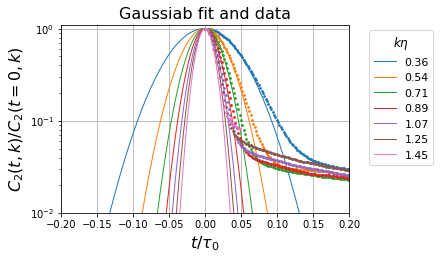

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
x2 = np.concatenate((-1.0*np.flip(x[1::]),x))
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    ax.plot(x[sl], simu['corr'][sl,ik] / simu['corr'][0,ik], '.', color=colors[i], markersize=3.5)
    #ax.plot(simu['time'][sl]/simu['t0'], simple_gaussian(x[sl], *simu['optim_coef_s'][ik,:]), linewidth=1, color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    ax.plot(x2, exp_poly_s(x2, *simu['optim_coef_s'][ik,:]), linewidth=1, color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title='Gaussiab fit and data'); ax.grid()
ax.set(ylim=[10e-3,1.1], xlim=[-0.2,0.2])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$', title_fontsize=12)

# pp = PdfPages('Images/Correlations/2pcorr_small2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

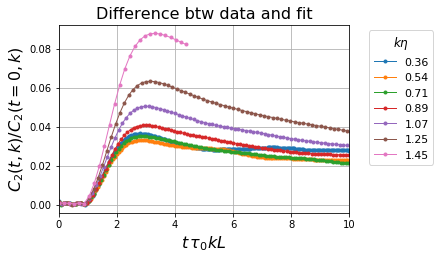

In [47]:
# difference between the fit and data
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    ax.plot(simu['time'][sl]/simu['t0']*(simu['k'][ik]*simu['L'])**1, np.abs(simu['corr'][sl,ik] / simu['corr'][0,ik] - exp_poly_s(x[sl], *simu['optim_coef_s'][ik,:])), '.-', linewidth=1, color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['eta'])) #ls=(0, (3, 5)),
ax.set(xscale='linear',yscale='linear', xlabel=r'$t\/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title='Difference btw data and fit'); ax.grid()
ax.set(xlim=[0,10.0])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$', title_fontsize=12)

# Large time fit

In [48]:
min_number_of_points = 20

# distance from crossover time to the beginning of the fit (in units t/t0 kL)
begin_dtp = 0.75

# distance from crossover time to the end of the fit (in units t/t0 kL)
end_dtp = 4.5

In [49]:
for simu in data_set : 
    simu['optim_coef_l'] = np.ndarray(shape=(len(simu['k']), 2), dtype=float)
    simu['optim_coef_l_var'] = np.ndarray(shape=(len(simu['k']), 2, 2), dtype=float)
    for ik in range(len(simu['k'])) :
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        begin_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) 
        #end_fit = np.min([np.searchsorted(simu['time']/simu['t0'], 0.5), simu['it_max'][ik]])
        end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) 
        if (begin_fit < simu['it_max'][ik]):
            if (end_fit < simu['it_max'][ik]) :
                sl = np.s_[begin_fit:end_fit]
            else :
                sl = np.s_[begin_fit:simu['it_max'][ik]]
            if ((len(simu['time'][sl]) > min_number_of_points)) :
                try :
                    simu['optim_coef_l'][ik, :], simu['optim_coef_l_var'][ik, :, :] = np.polyfit(simu['time'][sl]/simu['t0'], np.log(simu['corr'][sl,ik]/simu['corr'][0,ik]), 1, cov='True')
                #simu['optim_coef_l'][ik, :] = try_to_fit(simple_exponent, simu['time'][a_l:b_l]/simu['t0'], simu['corr'][a_l:b_l,ik]/simu['corr'][0,ik],jacobian_function=simple_exponent_jacobian)[0]
                except :
                    #print('Failed polyfit for ik = ', ik)
                    simu['optim_coef_l'][ik,:].fill(np.nan)
                    continue
        else:
            simu['optim_coef_l'][ik,:].fill(np.nan)

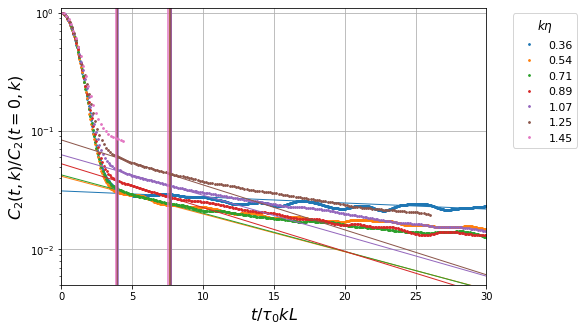

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(8,4.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    ax.plot(x[sl], simu['corr'][sl,ik] / simu['corr'][0,ik], '.', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    
    ax.plot(x, exp_poly_l(simu['time']/simu['t0'], *simu['optim_coef_l'][ik,:]), linewidth=1, color=colors[i]) 
    t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
    it_crossover = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) 
    #end_fit = np.min([np.searchsorted(simu['time']/simu['t0'], 1.0), simu['it_max'][ik]])
    end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) 
    
    ax.axvline(x=simu['time'][it_crossover]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
    ax.axvline(x=simu['time'][end_fit]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title=None); ax.grid()
ax.set(ylim=[5e-3,1.1], xlim=[0,30])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$', title_fontsize=12)

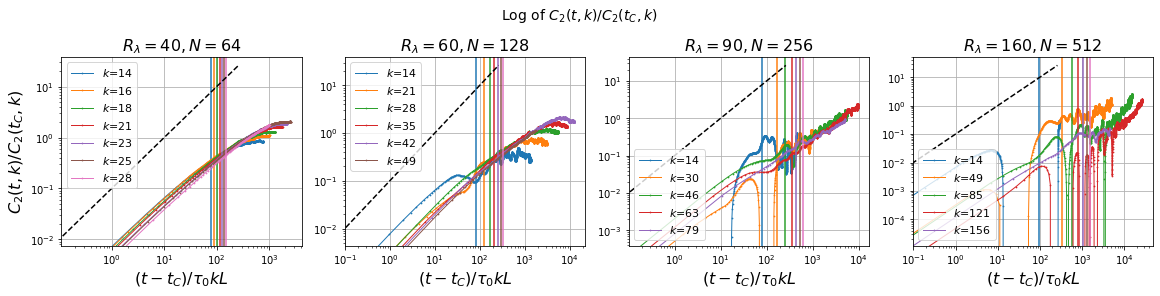

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Log of $C_2(t,k) / C_2(t_C,k)$ ', size=14) 

powerKl = 2
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for iik in range(len(simu['indices_of_k_to_plot'])) :
        ik = simu['indices_of_k_to_plot'][iik]
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        begin_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) 
        end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) 
        
        if (simu['it_max'][ik] > crossover_index) :
            time_sl = np.s_[begin_fit:simu['it_max'][ik]]
            ax[i].plot((simu['time'][time_sl]-simu['time'][begin_fit])/simu['t0']*(simu['k'][ik]*simu['L'])**powerKl, \
                   -np.log(simu['corr'][time_sl,ik] / simu['corr'][begin_fit,ik]), '.-', label=r'$k$=%2.0f' % (simu['k'][ik]), lw = 1, markersize=1.5)
        
        # put vertical bars corresponding to the end of the lin fit 
        ax[i].axvline(x=(simu['time'][end_fit]-simu['time'][begin_fit])/simu['t0']*(simu['k'][ik]*simu['L'])**powerKl, color=colors[iik])
    ax[i].plot(x,1e-1*x, 'k--')
    #ax[i].plot(x,10e-0*x**2, 'r--')
    ax[i].set(xscale='log',yscale='log', xlabel=r'$(t-t_C)/\tau_0 kL$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,2000.0])
    #ax[i].set(ylim=[0.1,1.0])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t_C,k)$')
    lgd = ax[i].legend(loc='best')

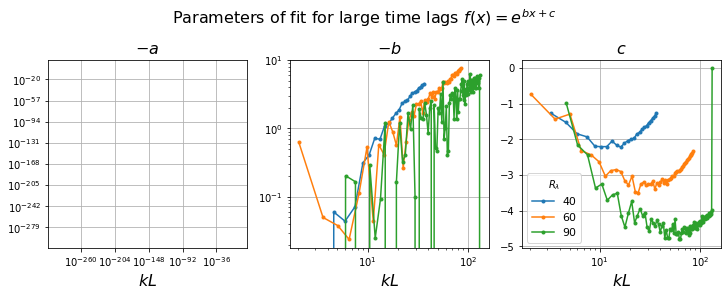

In [52]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
for simu in data_set[:3] : 
    sl = np.s_[0:np.int_(0.95*simu['ik_max'])]
    x = simu['k'][sl]*simu['L']
    #ax_a.plot(x, -simu['optim_coef_l'][sl, 0], '.-')
    ax_b.plot(x, -simu['optim_coef_l'][sl, 0], '.-')
    ax_c.plot(x, simu['optim_coef_l'][sl, 1], '.-', label=simu['Rl'])
#ax_a.plot(x, 10e-6*(x)**2, 'k--')
#ax_b.plot(x, 10e-6*(x)**2, 'k--')
ax_a.set(xscale='log', yscale='log', title=r'$-a$', xlabel=r'$kL$'); ax_a.grid(); #ax_a.legend()
ax_b.set(xscale='log', yscale='log', title=r'$-b$', xlabel=r'$kL$'); ax_b.grid(); 
ax_c.set(xscale='log', yscale='linear', title=r'$c$', xlabel=r'$kL$'); ax_c.grid(); ax_c.legend(title=r'$R_\lambda$')
fig.suptitle('Parameters of fit for large time lags $f(x) = e^{b x + c}$', fontsize=16)
# ax_a.set(ylim=[-0.0000,0.2])
# ax_b.set(ylim=[-0.00005,0.0005])
# pp = PdfPages('../Images/Correlations/norm_corr_fit_alphas.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


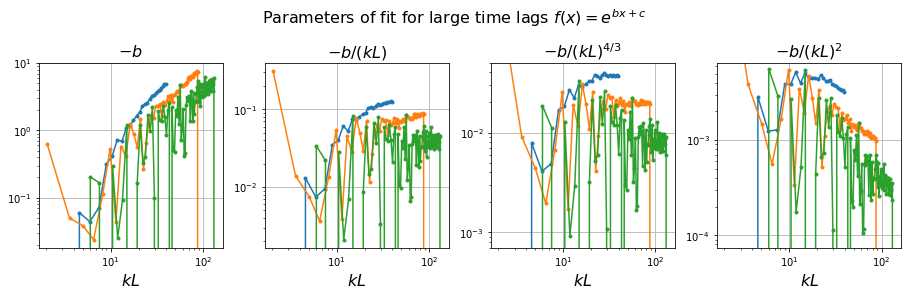

In [53]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c, ax_d) = plt.subplots(nrows=1, ncols=4,figsize=(12.5,4), constrained_layout=True)
for simu in data_set[0:-1] : 
    sl = np.s_[0:simu['ik_max']]
    ax_a.plot(simu['k'][sl]*simu['L'], -simu['optim_coef_l'][sl, 0], '.-')
    ax_b.plot(simu['k'][sl]*simu['L'], -simu['optim_coef_l'][sl, 0]/(simu['k'][sl]*simu['L']), '.-')
    ax_c.plot(simu['k'][sl]*simu['L'], -simu['optim_coef_l'][sl, 0]/((simu['k'][sl]*simu['L'])**(4/3)), '.-')
    ax_d.plot(simu['k'][sl]*simu['L'], -simu['optim_coef_l'][sl, 0]/((simu['k'][sl]*simu['L'])**(2)), '.-')
ax_a.set(xscale='log', yscale='log', title=r'$-b$', xlabel=r'$kL$'); ax_a.grid(); #ax_a.legend()
ax_b.set(xscale='log', yscale='log', title=r'$-b/(kL)$', xlabel=r'$kL$'); ax_b.grid(); 
ax_c.set(xscale='log', yscale='log', title=r'$-b/(kL)^{4/3}$', xlabel=r'$kL$'); ax_c.grid(); ax_c.set(ylim=[-0.001,0.05])
ax_d.set(xscale='log', yscale='log', title=r'$-b/(kL)^2$', xlabel=r'$kL$'); ax_d.grid(); ax_d.set(ylim=[-0.001,0.0065])
fig.suptitle('Parameters of fit for large time lags $f(x) = e^{bx + c}$', fontsize=16)

# pp = PdfPages('../Images/Correlations/norm_corr_fit_alphas.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


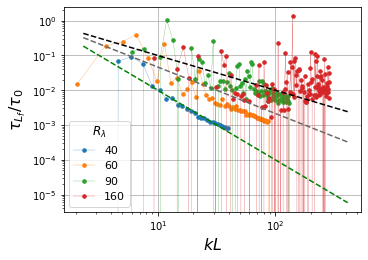

In [54]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    #ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = 1
    indices = np.s_[0:simu['ik_max']]
    normalization = 1.0
    dictionary = simu['corr']
    x = simu['k'][indices]*simu['L']
    ax.plot(x, -1.0/simu['optim_coef_l'][indices,0]/simu['t0'], 'o-', label=simu['Rl'], markersize=3.5, lw=0.25)
ax.plot(x, 10e-1*(x)**(-2), 'g--')
ax.plot(x, 10e-1*(x)**(-1), 'k--')
ax.plot(x, 10e-1*(x)**(-4.0/3.0), '--', color='dimgray')
#ax.annotate(r'$k^{-1}$', xy=(250, 1.5e-1), xycoords='data', size='16')
#ax.annotate(r'$k^{-2}$', xy=(250, 2.0e-2), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\tau_{L_f}/\tau_0$'); ax.grid()
#ax.set(xlim=[0.015,2.0])
#ax.set(xlim=[5,1e3]); ax.set(ylim=[1,10e5])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/tauLvsKL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':


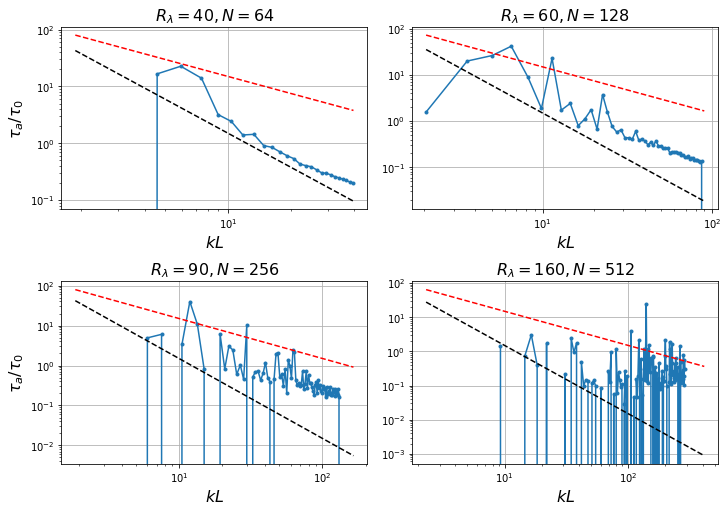

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True,figsize=(10,7))
plot_matrix = np.array(list(range(len(data_set)))).reshape((2,2))
for i in list(range(2)) :
    for j in list(range(2)) :
        simu = data_set[plot_matrix[i,j]]
        indices = np.s_[0:simu['ik_max']]
        x = simu['k'][indices]*simu['L']
        #ax[i,j].errorbar(x, -simu['optim_coef_l'][indices,0], yerr=np.sqrt(simu['optim_coef_l_var'][indices,0,0]))
        ax[i,j].plot(x, -1.0/simu['optim_coef_l'][indices,0],'.-')
        ax[i,j].plot(x, 1.5e2*(x)**(-2), 'k--')
        ax[i,j].plot(x, 1.5e2*(x)**(-1), 'r--')
        ax[i,j].set(xscale='log',yscale='log', xlabel=r'$kL$', title=simu['legend']); ax[i,j].grid()
        if (j == 0) : ax[i,j].set(ylabel=r'$\tau_a/\tau_0$')
        #lgd = ax[i].legend(loc='upper right')

In [56]:
def find_plateau(data) :
    N = len(data)
    Nmin = N//2
    a = 0; b = N-1
    minAlign = np.max(data-np.mean(data))/np.float(b-a+1)
    for i in list(range(0, N-Nmin-1)) :
        for j in list(range(i+Nmin, N-1)) :
            newAlign = np.max(data[i:j]-np.mean(data[i:j]))/np.float(j-i+1)
            if (newAlign < minAlign) :
                minAlign = newAlign
                a = i; b = j
    return np.mean(data[a:b]), np.std(data[a:b]), (b-a+1), a, b

# Match 2 fits

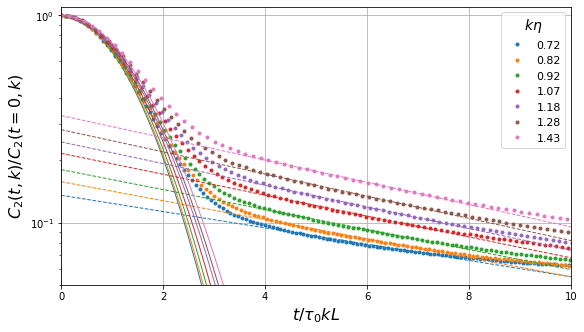

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(8,4.5))
simu = data_set[0] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    ax.plot(x[sl], simu['corr'][sl,ik] / simu['corr'][0,ik], 'o', color=colors[i], markersize=3.0, label=r'%2.2f' % (simu['k'][ik]*simu['eta']))
    ax.plot(x[sl], exp_poly_s(simu['time'][sl]/simu['t0'], *simu['optim_coef_s'][ik,:]), '-',linewidth=1, color=colors[i])
    ax.plot(x, exp_poly_l(simu['time']/simu['t0'], *simu['optim_coef_l'][ik,:]), '--', linewidth=1, color=colors[i]) 
    t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
    it_crossover = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) 
    #end_fit = np.min([np.searchsorted(simu['time']/simu['t0'], 1.0), simu['it_max'][ik]])
    end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) 
    
    #ax.axvline(x=simu['time'][it_crossover]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
    #ax.axvline(x=simu['time'][end_fit]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title=None); ax.grid()
ax.set(ylim=[5e-2,1.1], xlim=[0,10])
lgd = ax.legend(loc='best', title=r'$k\eta$', title_fontsize=14)

In [58]:
# intersection of 2 fits
for simu in data_set : 
    simu['fit_cross_time'] = np.ndarray(shape=len(simu['k']), dtype=float)
    for ik in range(len(simu['k'])) :
        a1 = simu['optim_coef_s'][ik,0]; b1 = simu['optim_coef_s'][ik,1]; c1 = simu['optim_coef_s'][ik,2]
        b2 = simu['optim_coef_l'][ik,0]; c2 = simu['optim_coef_l'][ik,1]
        simu['fit_cross_time'][ik] = ((b2-b1) - np.sqrt((b2-b1)*(b2-b1) - 4.0*a1*(c1-c2)))/(2.0*a1)

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


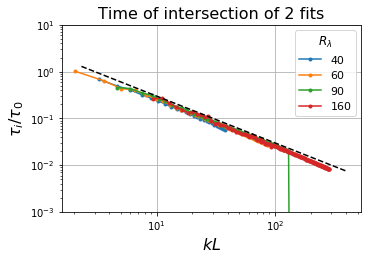

In [59]:
# plot time of intersection vs k
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    indices = np.s_[0:simu['ik_max']-1]
    x = simu['k'][indices]*simu['L']
    ax.plot(simu['k'][indices]*simu['L'], simu['fit_cross_time'][indices], '.-', label=simu['Rl'])
# ax.plot(x, 10e-1*(x)**(-2), 'g--')
ax.plot(x, 3e-0*(x)**(-1), 'k--')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\tau_{i}/\tau_0$', title='Time of intersection of 2 fits'); ax.grid()

ax.set(ylim=[10e-4,10e0])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)

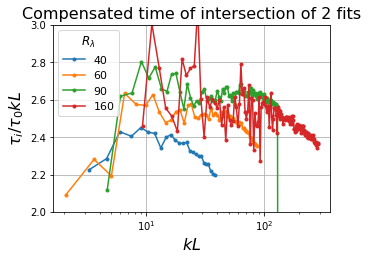

In [60]:
# plot time of intersection vs k
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    indices = np.s_[0:simu['ik_max']-1]
    x = simu['k'][indices]*simu['L']
    ax.plot(x, simu['fit_cross_time'][indices]*(x**1), '.-', label=simu['Rl'])
ax.set(xscale='log', yscale='linear', xlabel=r'$kL$',ylabel=r'$\tau_{i}/\tau_0 kL$', title='Compensated time of intersection of 2 fits'); ax.grid()
ax.set(ylim=[2,3])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)

# Fit at very large times

In [61]:
min_number_of_points = 20
begin_dtp = 0.75
end_dtp = 5.0
end_dtp2 = 22.0

In [62]:
for simu in data_set : 
    simu['optim_coef_l2'] = np.ndarray(shape=(len(simu['k']), 2), dtype=float)
    simu['optim_coef_l_var2'] = np.ndarray(shape=(len(simu['k']), 2,2), dtype=float)
    for ik in range(len(simu['k'])) :
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        begin_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) 
        #end_fit = np.min([np.searchsorted(simu['time']/simu['t0'], 0.5), simu['it_max'][ik]])
        end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) 
        
        if (begin_fit < simu['it_max'][ik]):
            if (end_fit < simu['it_max'][ik]) :
                sl = np.s_[begin_fit:end_fit]
            else :
                sl = np.s_[begin_fit:simu['it_max'][ik]]
            if ((len(simu['time'][sl]) > min_number_of_points)) :
                try :
                    simu['optim_coef_l2'][ik, :], simu['optim_coef_l_var2'][ik, :, :] = np.polyfit(simu['time'][sl]/simu['t0'], np.log(simu['corr'][sl,ik]/simu['corr'][0,ik]), 1, cov='True')
                #simu['optim_coef_l'][ik, :] = try_to_fit(simple_exponent, simu['time'][a_l:b_l]/simu['t0'], simu['corr'][a_l:b_l,ik]/simu['corr'][0,ik],jacobian_function=simple_exponent_jacobian)[0]
                except :
                    #print('Failed polyfit for ik = ', ik)
                    simu['optim_coef_l2'][ik,:].fill(np.nan)
                    continue
        else:
            simu['optim_coef_l2'][ik,:].fill(np.nan)

'saved to fig312_k='

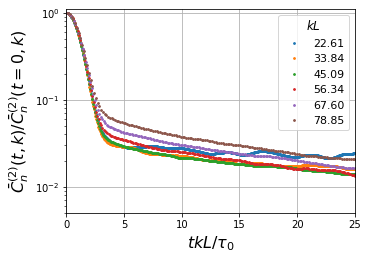

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:-1])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    #sl = np.s_[0:-1]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    ax.plot(x[sl], simu['corr'][sl,ik] / simu['corr'][0,ik], '.', color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L']))
    #ax.plot(x, exp_poly_l(simu['time']/simu['t0'], *simu['optim_coef_l'][ik,:]), linewidth=1, color=colors[i]) 
    #ax.plot(x, exp_poly_l(simu['time']/simu['t0'], *simu['optim_coef_l2'][ik,:]), '--', linewidth=1, color=colors[i]) 
    t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
    begin_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) -1
    end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) -1
#     print(simu['time'][begin_fit]/simu['t0']*(simu['k'][ik]*simu['L']))
#     print(simu['time'][end_fit]/simu['t0']*(simu['k'][ik]*simu['L']))
#     ax.axvline(x=simu['time'][begin_fit]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
#     ax.axvline(x=simu['time'][end_fit]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
ax.set(xscale='linear',yscale='log', xlabel=r'$tkL/\tau_0$', ylabel=r'$\bar{C}_n^{(2)}(t,k) / \bar{C}_n^{(2)}(t=0,k)$', title=None); ax.grid()
ax.set(ylim=[0.5e-2,1.1], xlim=[0,25])
lgd = ax.legend(loc='best', title=r'$kL$', title_fontsize=12)

# plt.text(0.11, 0.92, "Gaussian", {'color': 'darkgreen', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
# #ax.axvspan(7.9, 15 , facecolor='purple', alpha=0.15)
# plt.text(0.76, 0.92, "Exponential", {'color': 'darkviolet', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
# plt.text(0.35, 0.5, "Crossover", {'color': 'black', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)

# left_border = 0.0
# right_border = 2.2
# cols_number = 10
# alphas = np.flip(np.linspace(0, 0.35, cols_number))
# cols = np.linspace(left_border, right_border, cols_number)
# for ic in list(range(len(cols)-2)) : 
#     a = cols[ic]
#     b = cols[ic + 1]
#     plt.axvspan(a, b, facecolor='green', alpha=alphas[ic])

# left_border = 7.0
# right_border = 26
# cols_number = 25
# alphas = np.linspace(0, 0.6, cols_number)
# cols = np.linspace(left_border, right_border, cols_number)
# for ic in list(range(len(cols)-2)) : 
#     a = cols[ic]
#     b = cols[ic + 1]
#     plt.axvspan(a, b, facecolor='purple', alpha=alphas[ic])
#get_plot_data_blocks(ax,'fig312_k=')
#pp = PdfPages('../Images/Paper/tempslargeCorr.pdf') 
#pp.savefig(bbox_inches='tight')
#pp.close()

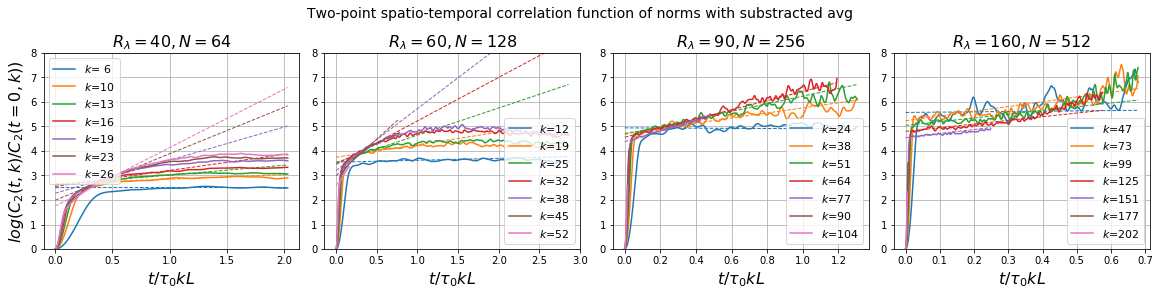

In [64]:
# log of C2
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 

k_power = 0
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for iik in range(len(simu['indices_of_k_to_plot2'])) :
        ik = simu['indices_of_k_to_plot2'][iik]
        time_sl = np.s_[0:simu['it_max'][ik]]
        t_prime = simu['time'][time_sl]/simu['t0']*(simu['k'][ik]*simu['L'])**k_power
#         begin_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) -1
#         end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) -1
        ax[i].plot(t_prime, -np.log(simu['corr'][time_sl,ik] / simu['corr'][0,ik]), '-', label=r'$k$=%2.0f' % (simu['k'][ik]), color=colors[iik])
        ax[i].plot(t_prime, -np.log(exp_poly_l(simu['time'][time_sl]/simu['t0'], *simu['optim_coef_l2'][ik,:])), '--', linewidth=1, color=colors[iik]) 
    #x[i].plot(x, x**2, 'k--', label=r'$t^2$')
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0 k L$', title=simu['legend']); ax[i].grid()
    ax[i].set(ylim=[0,8.0])
    if (i == 0) : ax[i].set(ylabel=r'$log(C_2(t,k) / C_2(t=0,k))$')
    lgd = ax[i].legend(loc='best')

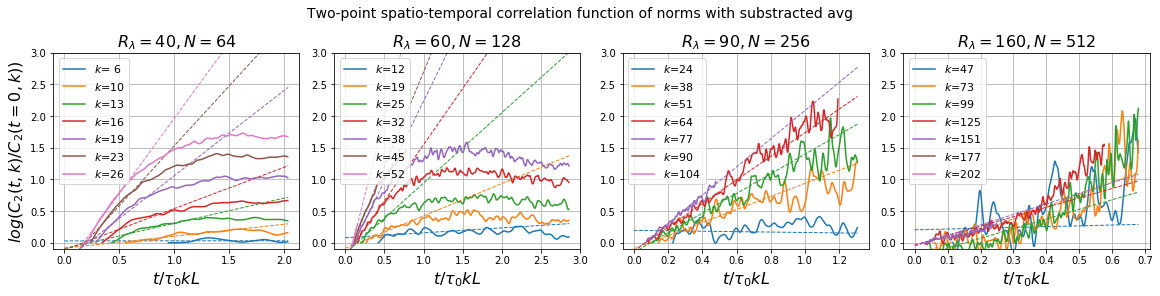

In [65]:
# log of C2
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Two-point spatio-temporal correlation function of norms with substracted avg', size=14) 
k_power = 0
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for iik in range(len(simu['indices_of_k_to_plot2'])) :
        ik = simu['indices_of_k_to_plot2'][iik]
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        begin_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) -1
        end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) -1
        time_sl = np.s_[begin_fit:simu['it_max'][ik]]
        ax[i].plot(simu['time'][time_sl]/simu['t0']*(simu['k'][ik]*simu['L'])**k_power, -np.log(simu['corr'][time_sl,ik] / simu['corr'][begin_fit,ik]), '-', label=r'$k$=%2.0f' % (simu['k'][ik]), color=colors[iik])
        ax[i].plot(simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**k_power, -np.log(exp_poly_l(simu['time'][:]/simu['t0'], *simu['optim_coef_l2'][ik,:])*simu['corr'][0,ik]/simu['corr'][begin_fit,ik]), '--', linewidth=1, color=colors[iik]) 
    #x[i].plot(x, x**2, 'k--', label=r'$t^2$')
    ax[i].set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0 k L$', title=simu['legend']); ax[i].grid()
    ax[i].set(ylim=[-0.1,3.0])
    if (i == 0) : ax[i].set(ylabel=r'$log(C_2(t,k) / C_2(t=0,k))$')
    lgd = ax[i].legend(loc='best')

In [66]:
# # difference between the fit and data
# fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(6,3.5))
# simu = data_set[1] 
# x = simu['time']/simu['t0']
# for i in range(len(simu['indices_of_k_to_plot'][:])) :
#     t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
#     it_crossover = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) 
#     ik = simu['indices_of_k_to_plot'][i]
#     sl = np.s_[it_crossover:simu['it_max'][ik]]
#     ax.plot(simu['time'][sl]/simu['t0']*(simu['k'][ik]*simu['L'])**1, simu['corr'][sl,ik] / simu['corr'][0,ik] - exp_poly_l(simu['time'][sl]/simu['t0'], *simu['optim_coef_l2'][ik,:]) , '.-', linewidth=1, color=colors[i], label=r'%2.2f' % (simu['k'][ik]*simu['eta'])) #ls=(0, (3, 5)),
# ax.set(xscale='linear',yscale='linear', xlabel=r'$t\/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title='Difference btw data and fit'); ax.grid()
# ax.set(xlim=[0,35])
# lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k\eta$', title_fontsize=12)

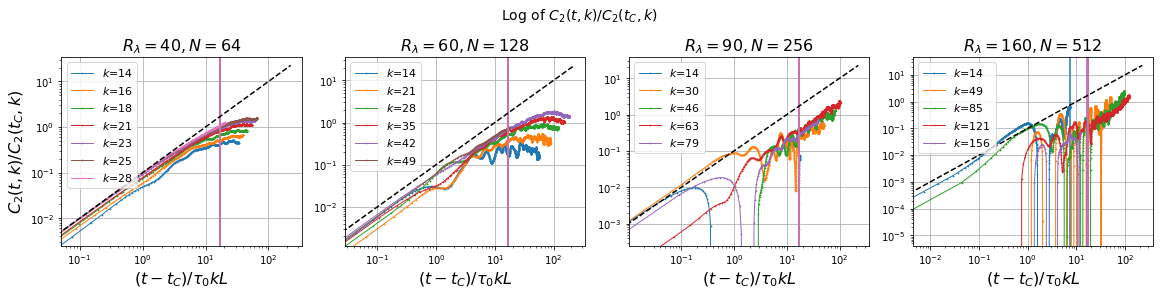

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(3*len(data_set)+4,4))
fig.suptitle(r'Log of $C_2(t,k) / C_2(t_C,k)$ ', size=14) 

powerKl =1
for i in list(range(len(data_set))) :
    simu = data_set[i]
    for iik in range(len(simu['indices_of_k_to_plot'])) :
        ik = simu['indices_of_k_to_plot'][iik]
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        begin_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) 
        end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) -1 
        
        if (simu['it_max'][ik] > crossover_index) :
            time_sl = np.s_[begin_fit:simu['it_max'][ik]]
            ax[i].plot((simu['time'][time_sl]-simu['time'][begin_fit])/simu['t0']*(simu['k'][ik]*simu['L'])**powerKl, \
                   -np.log(simu['corr'][time_sl,ik] / simu['corr'][begin_fit,ik]), '.-', label=r'$k$=%2.0f' % (simu['k'][ik]), lw = 1, markersize=1.5)
        
        # put vertical bars corresponding to the end of the lin fit 
        ax[i].axvline(x=(simu['time'][end_fit]-simu['time'][begin_fit])/simu['t0']*(simu['k'][ik]*simu['L'])**powerKl, color=colors[iik])
    ax[i].plot(x,1e-1*x, 'k--')
    #ax[i].plot(x,10e-0*x**2, 'r--')
    ax[i].set(xscale='log',yscale='log', xlabel=r'$(t-t_C)/\tau_0 kL$', title=simu['legend']); ax[i].grid()
    #ax[i].set(xlim=[0,2000.0])
    #ax[i].set(ylim=[0.1,1.0])
    if (i == 0) : ax[i].set(ylabel=r'$C_2(t,k) / C_2(t_C,k)$')
    lgd = ax[i].legend(loc='best')

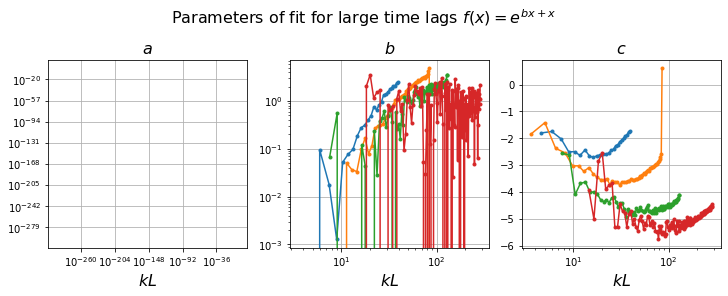

In [68]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
for simu in data_set[0:] : 
    sl = np.s_[0:simu['ik_max']]
    #ax_a.plot(simu['k'][sl]*simu['L'], -simu['optim_coef_l2'][sl, 0]/(simu['k'][sl]*simu['L'])**0, '.-')
    ax_b.plot(simu['k'][sl]*simu['L'], -simu['optim_coef_l2'][sl, 0]/(simu['k'][sl]*simu['L'])**0, '.-')
    ax_c.plot(simu['k'][sl]*simu['L'], simu['optim_coef_l2'][sl, 1], '.-')
ax_a.set(xscale='log', yscale='log', title=r'$a$', xlabel=r'$kL$'); ax_a.grid(); #ax_a.legend()
ax_b.set(xscale='log', yscale='log', title=r'$b$', xlabel=r'$kL$'); ax_b.grid(); 
ax_c.set(xscale='log', yscale='linear', title=r'$c$', xlabel=r'$kL$'); ax_c.grid()
fig.suptitle('Parameters of fit for large time lags $f(x) = e^{bx + x}$', fontsize=16)

# pp = PdfPages('../Images/Correlations/norm_corr_fit_alphas.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


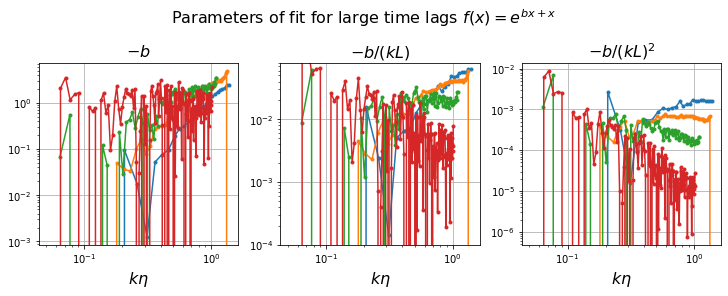

In [69]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
for simu in data_set[0:] : 
    sl = np.s_[0:simu['ik_max']]
    ax_a.plot(simu['k'][sl]*simu['eta'], -simu['optim_coef_l2'][sl, 0], '.-')
    ax_b.plot(simu['k'][sl]*simu['eta'], -simu['optim_coef_l2'][sl, 0]/(simu['k'][sl]*simu['L']), '.-')
    ax_c.plot(simu['k'][sl]*simu['eta'], -simu['optim_coef_l2'][sl, 0]/((simu['k'][sl]*simu['L'])**(2)), '.-')
ax_a.set(xscale='log', yscale='log', title=r'$-b$', xlabel=r'$k\eta$'); ax_a.grid(); #ax_a.legend()
ax_b.set(xscale='log', yscale='log', title=r'$-b/(kL)$', xlabel=r'$k\eta$'); ax_b.grid(); ax_b.set(ylim=[-0.01,0.08])
ax_c.set(xscale='log', yscale='log', title=r'$-b/(kL)^2$', xlabel=r'$k\eta$'); ax_c.grid(); #ax_c.set(ylim=[-0.001,0.0025])
fig.suptitle('Parameters of fit for large time lags $f(x) = e^{bx + x}$', fontsize=16)

# pp = PdfPages('../Images/Correlations/norm_corr_fit_alphas.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

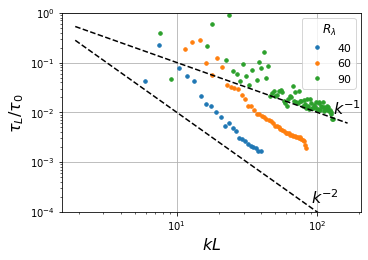

In [70]:
# results of fit
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set[0:3]))) :
    simu = data_set[i]
    #ik_min_decorr = np.transpose(np.nonzero(simu['corr']['data'][:,:]<10e-9))[0,0]
    ik1 = 1
    indices = np.s_[0:simu['ik_max']]
    normalization = 1.0
    dictionary = simu['corr']
    x = simu['k'][indices]*simu['L']
    ax.plot(x, -1.0/simu['optim_coef_l2'][indices,0]/simu['t0'], 'o', label=simu['Rl'], markersize=3.5, lw=0.25)
ax.plot(x, 10e-1*(x)**(-2), 'k--')
ax.plot(x, 10e-1*(x)**(-1), 'k--')
ax.annotate(r'$k^{-1}$', xy=(130, 9e-3), xycoords='data', size='16')
ax.annotate(r'$k^{-2}$', xy=(90, 1.5e-4), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\tau_{L}/\tau_0$'); ax.grid()
#ax.set(xlim=[0.015,2.0])
ax.set(ylim=[10e-5,1e0])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Python/Images/Paper/tauLvsKL.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

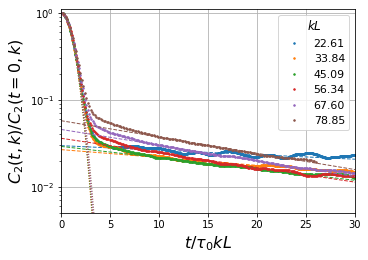

In [71]:
# match with the gaussian
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:-1])) :
    ik = simu['indices_of_k_to_plot'][i]
    sl = np.s_[0:simu['it_max'][ik]]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    ax.plot(x[sl], simu['corr'][sl,ik] / simu['corr'][0,ik], '.', color=colors[i], markersize=3.0, label=r'%2.2f' % (simu['k'][ik]*simu['L']))
    ax.plot(x[sl], exp_poly_s(simu['time'][sl]/simu['t0'], *simu['optim_coef_s'][ik,:]), ':',linewidth=1, color=colors[i])
    ax.plot(x, exp_poly_l(simu['time']/simu['t0'], *simu['optim_coef_l2'][ik,:]), '--', linewidth=1, color=colors[i]) 
    t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
    it_crossover = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) 
    #end_fit = np.min([np.searchsorted(simu['time']/simu['t0'], 1.0), simu['it_max'][ik]])
    end_fit = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) -1
    end_fit2 = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) -1
    #ax.axvline(x=simu['time'][it_crossover]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
    #ax.axvline(x=simu['time'][end_fit]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
    #ax.axvline(x=simu['time'][end_fit2]/simu['t0']*(simu['k'][ik]*simu['L'])**1, color=colors[i])
ax.set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0 kL$', ylabel=r'$C_2(t,k) / C_2(t=0,k)$', title=None); ax.grid()
ax.set(ylim=[0.5e-2,1.1], xlim=[0,30])
lgd = ax.legend(loc='best', title=r'$kL$', title_fontsize=12)

# pp = PdfPages('Images/Correlations/tempslargeCorr2.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

In [72]:
# intersection of 2 fits
for simu in data_set : 
    simu['fit_cross_time2'] = np.ndarray(shape=len(simu['k']), dtype=float)
    for ik in range(len(simu['k'])) :
        a1 = simu['optim_coef_s'][ik,0]; b1 = simu['optim_coef_s'][ik,1]; c1 = simu['optim_coef_s'][ik,2]
        b2 = simu['optim_coef_l2'][ik,0]; c2 = simu['optim_coef_l2'][ik,1]
        simu['fit_cross_time2'][ik] = ((b2-b1) - np.sqrt((b2-b1)*(b2-b1) - 4.0*a1*(c1-c2)))/(2.0*a1)

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


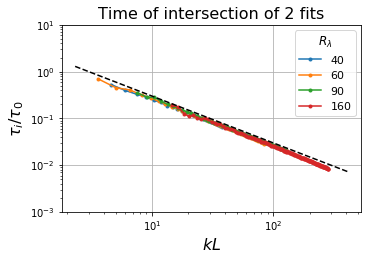

In [73]:
# plot time of intersection vs k
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    indices = np.s_[0:simu['ik_max']-1]
    x = simu['k'][indices]*simu['L']
    ax.plot(simu['k'][indices]*simu['L'], simu['fit_cross_time2'][indices], '.-', label=simu['Rl'])
# ax.plot(x, 10e-1*(x)**(-2), 'g--')
ax.plot(x, 3e-0*(x)**(-1), 'k--')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$',ylabel=r'$\tau_{i}/\tau_0$', title='Time of intersection of 2 fits'); ax.grid()

ax.set(ylim=[10e-4,10e0])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)

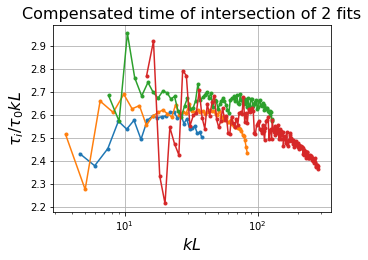

In [74]:
# plot time of intersection vs k
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5,3.5))
for i in list(range(len(data_set))) :
    simu = data_set[i]
    indices = np.s_[0:simu['ik_max']-1]
    x = simu['k'][indices]*simu['L']
    ax.plot(x, simu['fit_cross_time2'][indices]*(x**(1)), '.-', label=simu['Rl'])
ax.set(xscale='log', yscale='linear', xlabel=r'$kL$',ylabel=r'$\tau_{i}/\tau_0 kL$', title='Compensated time of intersection of 2 fits'); ax.grid()
#ax.set(ylim=[2,3])
#lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
plt.show()

# Integral decorrelation times

In [75]:
# #integral decorrelation time of C2
# fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,4))
# for i in list(range(len(data_set))) :
#     simu = data_set[i]
#     data_dict=simu['corr']
#     simu.update({'short_decorrelation_time' : np.ndarray(shape=(len(simu['k']),1), dtype=float)}) #allocate
#     for ik in list(range(len(simu['k']))) : 
#         try:
#             half_index = len(simu['time']) - np.searchsorted(np.flip(simu['corr'][:,ik]/simu['corr'][0,ik]), 1.0/np.e,side='left')
#             simu['short_decorrelation_time'][ik] = simu['time'][half_index]
#         except : 
#             half_index = len(simu['time']) - 1
#             simu['short_decorrelation_time'][ik] = simu['time'][-1]
#     x = simu['k'][:simu['ik_max']]*simu['L']
#     #ax.plot(simu['k'][::]*simu['eta'], simu['short_decorrelation_time']/simu['t0'], '.-', label=simu['Rl'])
#     ax.plot(x, np.sqrt(-1.0/simu['optim_coef_s'][:simu['ik_max'], 0]), '.-', label=simu['Rl'])
# ax.plot(x, x**(-1.0), '--', label=r'$k^{-1}$')
# ax.plot(x, x**(-2.0/3.0), '--', label=r'$k^{-2/3}$')
# #     ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-1.0), '--', label=r'$k^{-1}$')
# #     ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-2.0/3.0), '--', label=r'$k^{-2/3}$')
# #ax.plot(x, np.full_like(x, simu['t0']))
# ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$\tau_S/\tau_0$', title=r'$\tau_s = \sqrt{1/a}$'); ax.grid()
# #ax.set(xlim=[0.01,2.0])
# lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
# #plt.show()
# # pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorrdecorrtimeallReketa.pdf')
# # pp.savefig(bbox_inches='tight')
# # pp.close()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


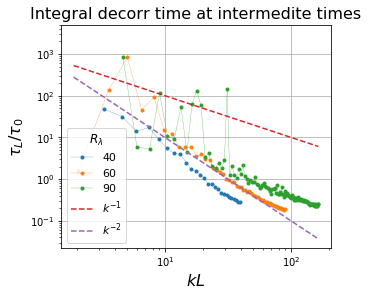

In [76]:
#integral decorrelation time of C2 
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,4))
for i in list(range(len(data_set[0:3]))) :
    simu = data_set[i]
    data_dict=simu['corr']
    simu.update({'long_decorrelation_time' : np.ndarray(shape=(len(simu['k'])), dtype=float)}) #allocate
    for ik in list(range(len(simu['k']))) : 
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        a_l = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) -1
        b_l = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) -1
        #print(t_prime[a_l])
        #b_l = simu['it_max'][ik]
        #b_l = np.min([np.searchsorted(simu['time']/simu['t0'], 0.7), simu['it_max'][ik]])
        if (a_l < b_l) :
            normalization = np.abs(1.0/(data_dict[a_l,ik] - data_dict[b_l,ik]))
            simu['long_decorrelation_time'][ik] = np.trapz(data_dict[a_l:b_l,ik] * normalization , x=simu['time'][a_l:b_l])
        else : 
            simu['long_decorrelation_time'][ik] = np.nan
    x = simu['k'][:simu['ik_max']]*simu['L']
    ax.plot(x, simu['long_decorrelation_time'][:simu['ik_max']]/simu['t0']*(x**(0)), '.-', label=simu['Rl'], lw=0.25)
ax.plot(x, 10e2*x**(-1), '--', label=r'$k^{-1}$')
# ax.plot(simu['k'][::]*simu['eta'], 10e1*x**(-2.0/3.0), '--',simu['k'] label=r'$k^{-2/3}$')
ax.plot(x, 10e2*x**(-2.0), '--', label=r'$k^{-2}$')
#     ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-1.0), '--', label=r'$k^{-1}$')
#     ax.plot(simu['k'][ik_min_decorr::]*simu['eta'], x**(-2.0/3.0), '--', label=r'$k^{-2/3}$')
#ax.plot(x, np.full_like(x, simu['t0']))
ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$\tau_L/\tau_0$', title='Integral decorr time at intermedite times'); ax.grid()
ax.set(ylim=[0.0,5000.0])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
#plt.show()
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorrdecorrtimeallReketa.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

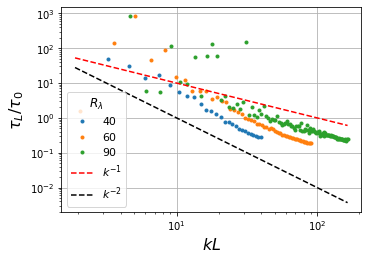

In [77]:
#integral decorrelation time of C2 
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
for i in list(range(len(data_set[0:3]))) :
    simu = data_set[i]
    data_dict=simu['corr']
    simu.update({'long_decorrelation_time' : np.ndarray(shape=(len(simu['k'])), dtype=float)}) #allocate
    for ik in list(range(len(simu['k']))) : 
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        a_l = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + begin_dtp) -1
        b_l = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) -1
        #b_l = simu['it_max'][ik]
        #b_l = np.min([np.searchsorted(simu['time']/simu['t0'], 0.6), simu['it_max'][ik]])
        if (a_l < b_l) :
            normalization = np.abs(1.0/(data_dict[a_l,ik] - data_dict[b_l,ik]))
            simu['long_decorrelation_time'][ik] = np.trapz(data_dict[a_l:b_l,ik] * normalization , x=simu['time'][a_l:b_l])
        else : 
            simu['long_decorrelation_time'][ik] = np.nan
    x = simu['k'][:simu['ik_max']]*simu['L']
    ax.plot(x, simu['long_decorrelation_time'][:simu['ik_max']]/simu['t0']*(x**(0)), '.', label=simu['Rl'])
ax.plot(x, 10e1*x**(-1.0), 'r--', label=r'$k^{-1}$')
ax.plot(x, 10e1*x**(-2.0), 'k--', label=r'$k^{-2}$')

ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$\tau_L/\tau_0$'); ax.grid()
#ax.set(ylim=[0.0,5000.0])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorrdecorrtimeallReketa.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

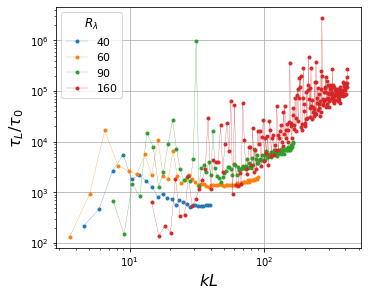

In [78]:
#integral decorrelation time of C2 
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,4))
for i in list(range(len(data_set[0:4]))) :
    simu = data_set[i]
    data_dict=simu['corr']
    simu.update({'long_decorrelation_time' : np.ndarray(shape=(len(simu['k'])), dtype=float)}) #allocate
    for ik in list(range(len(simu['k']))) : 
        t_prime = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])
        a_l = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp) -1
        b_l = np.searchsorted(t_prime, t_prime[simu['itc_deriv2'][ik]] + end_dtp2) - 1
        #b_l = simu['it_max'][ik]
        #b_l = np.min([np.searchsorted(simu['time']/simu['t0'], 0.6), simu['it_max'][ik]])
        if (a_l < b_l) :
            normalization = np.abs(1.0/(data_dict[a_l,ik] - data_dict[b_l,ik]))
            simu['long_decorrelation_time'][ik] = np.trapz(data_dict[a_l:b_l,ik] * normalization , x=simu['time'][a_l:b_l])
        else : 
            simu['long_decorrelation_time'][ik] = np.nan
    x = simu['k'][:simu['ik_max']]*simu['L']
    ax.plot(x, simu['long_decorrelation_time'][:simu['ik_max']]/simu['t0']*(x**(2)), '.-', label=simu['Rl'], lw=0.25)
ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$\tau_L/\tau_0$'); ax.grid()
#ax.set(ylim=[0.0,5000.0])
lgd = ax.legend(loc='best',title=r'$R_\lambda$', title_fontsize=12)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/tex_correlations/figures/2pcorrdecorrtimeallReketa.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

# Paper plots

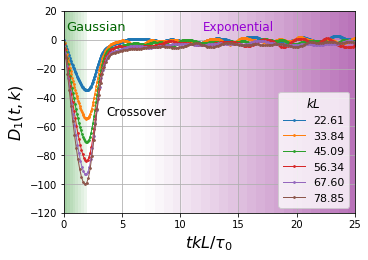

In [83]:
# check [c'(t)/c(t)]
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:-1])) :
    ik = simu['indices_of_k_to_plot'][i]
    time_sl = np.s_[0:simu['it_max'][ik]]
    #time_sl = np.s_[0:-1]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    #ax.plot(x[time_sl], simu['deriv1'][ik,time_sl]/(simu['corr'][time_sl,ik] / simu['corr'][0,ik]), '.-', linewidth=1, color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L'])) #ls=(0, (3, 5)),
    ax.plot(x[time_sl], simu['deriv1'][ik,time_sl], '.-', linewidth=1, color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L'])) #ls=(0, (3, 5)),
    #ax.plot(x, 2.0*simu['optim_coef_s'][ik, 0]*simu['time'][:]/simu['t0'], '-', linewidth=1, color=colors[i])
    #ax.axvline(x=x[simu['itc_deriv'][ik]], color=colors[i])
ax.set(xscale='linear',yscale='linear', xlabel=r'$t kL/\tau_0$', ylabel=r'$D_1(t, k)$'); ax.grid()
ax.set(xlim=[0,25.0], ylim=[-120,20])
lgd = ax.legend(loc='lower right', title=r'$kL$', title_fontsize=12)
#ax.axvspan(0, x[simu['itc_deriv'][ik]-3], facecolor='green', alpha=0.15)
plt.text(0.11, 0.92, "Gaussian", {'color': 'darkgreen', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
#ax.axvspan(7.9, 15 , facecolor='purple', alpha=0.15)
plt.text(0.6, 0.92, "Exponential", {'color': 'darkviolet', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
plt.text(0.25, 0.5, "Crossover", {'color': 'black', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)

left_border = 0.0
right_border = 2.2
cols_number = 10
alphas = np.flip(np.linspace(0.0, 0.35, cols_number))
cols = np.linspace(left_border, right_border, cols_number)
for ic in list(range(len(cols)-2)) : 
    a = cols[ic]
    b = cols[ic + 1]
    plt.axvspan(a, b, facecolor='green', alpha=alphas[ic])

left_border = 7.0
right_border = 26
cols_number = 25
alphas = np.linspace(0.01, 0.6, cols_number)
cols = np.linspace(left_border, right_border, cols_number)
for ic in list(range(len(cols)-2)) : 
    a = cols[ic]
    b = cols[ic + 1]
    plt.axvspan(a, b, facecolor='purple', alpha=alphas[ic])
#get_plot_data_blocks(ax,'fig313a_k=')
# pp = PdfPages('Images/Paper/derivC2vstk.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

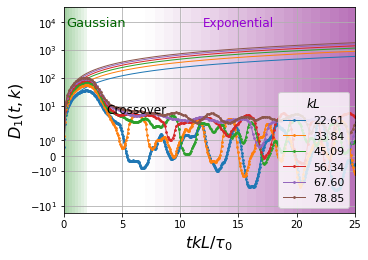

In [80]:
# check [c'(t)/c(t)]
fig, ax = plt.subplots(nrows=1, ncols=1,constrained_layout=True,figsize=(5,3.5))
simu = data_set[1] 
x = simu['time']/simu['t0']
for i in range(len(simu['indices_of_k_to_plot'][:-1])) :
    ik = simu['indices_of_k_to_plot'][i]
    time_sl = np.s_[0:simu['it_max'][ik]]
    x = simu['time']/simu['t0']*(simu['k'][ik]*simu['L'])**1
    #ax.plot(x[time_sl], simu['deriv1'][ik,time_sl]/(simu['corr'][time_sl,ik] / simu['corr'][0,ik]), '.-', linewidth=1, color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L'])) #ls=(0, (3, 5)),
    ax.plot(x[time_sl], -simu['deriv1'][ik,time_sl], '.-', linewidth=1, color=colors[i], markersize=3.5, label=r'%2.2f' % (simu['k'][ik]*simu['L'])) #ls=(0, (3, 5)),
    ax.plot(x, -2.0*simu['optim_coef_s'][ik, 0]*simu['time'][:]/simu['t0'], '-', linewidth=1, color=colors[i])
    #ax.axvline(x=x[simu['itc_deriv'][ik]], color=colors[i])
ax.set(xscale='linear',yscale='symlog', xlabel=r'$t kL/\tau_0$', ylabel=r'$D_1(t, k)$'); ax.grid()
ax.set(xlim=[0,25.0])
#ax.set(ylim=[-0.01,120])
lgd = ax.legend(loc='lower right', title=r'$kL$', title_fontsize=12)
#ax.axvspan(0, x[simu['itc_deriv'][ik]-3], facecolor='green', alpha=0.15)
plt.text(0.11, 0.92, "Gaussian", {'color': 'darkgreen', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
#ax.axvspan(7.9, 15 , facecolor='purple', alpha=0.15)
plt.text(0.6, 0.92, "Exponential", {'color': 'darkviolet', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
plt.text(0.25, 0.5, "Crossover", {'color': 'black', 'fontsize': 12}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)

left_border = 0.0
right_border = 2.2
cols_number = 10
alphas = np.flip(np.linspace(0.0, 0.35, cols_number))
cols = np.linspace(left_border, right_border, cols_number)
for ic in list(range(len(cols)-2)) : 
    a = cols[ic]
    b = cols[ic + 1]
    plt.axvspan(a, b, facecolor='green', alpha=alphas[ic])

left_border = 7.0
right_border = 26
cols_number = 25
alphas = np.linspace(0.01, 0.6, cols_number)
cols = np.linspace(left_border, right_border, cols_number)
for ic in list(range(len(cols)-2)) : 
    a = cols[ic]
    b = cols[ic + 1]
    plt.axvspan(a, b, facecolor='purple', alpha=alphas[ic])
    
# pp = PdfPages('Images/Paper/derivC2vstk.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()